In [1]:
import sys
import os
import re
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from load_dataset import load, generate_random_dataset
from classifier import *
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from operator import itemgetter
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
val_seeds = [42, 99, 67, 2, 23]
val_seed = val_seeds[0]

seed = 1
c = 0.003
epoch_num = 1000
th = 0.03

In [4]:
dataset = 'adult'
sens_attr = 'gender'
# subarea = 'Calcasieu'
subarea = 'Orleans'
scenario = 1

In [5]:
A = 'y'
A_val = 1
# A = None
# A_val = None
fair_metric = 0 if (A is None) else 1
assert (A=='y' and A_val==1) or (A==None)

In [6]:
clf_name = 'LogisticRegression'

## Preparation

**Load Dataset**

In [7]:
if dataset == 'hmda':
    if scenario>=7:
        X_train, X_test, y_train, y_test = load(dataset, subarea=subarea)
    else:
        epoch_num = 300
        X_train, X_test, y_train, y_test = load(dataset)
else:
    X_train, X_test, y_train, y_test = load(dataset)

**Parametric Model**

In [ ]:
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape[1], len(X_train_orig)+len(X_test_orig)

(8, 45222)

**Loss function** (Log loss for logistic regression)

In [ ]:
# clf = NeuralNetwork(input_size=X_train.shape[-1])
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM(input_size=X_train.shape[-1])
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch

In [ ]:
clf.__class__.__name__

'LogisticRegression'

**Metrics: Initial state**

In [ ]:
clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=1000, c=0.003)

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.19826196565747134
Initial TPR parity:  -0.17530348635736964
Initial predictive parity:  -0.18434572565844864
Initial loss:  0.3935996669291773
Initial accuracy:  0.8085657370517928


In [ ]:
X_train_orig.columns

Index(['age', 'workclass', 'education', 'marital', 'relationship', 'race',
       'gender', 'hours'],
      dtype='object')

Correlation Ranking

In [ ]:
for col in X_test_orig.columns:
    print(f'corr. between {col} and label: {np.round(np.corrcoef(X_test_orig[col], y_test)[0][1], 2)}')

corr. between age and label: 0.16
corr. between workclass and label: -0.09
corr. between education and label: 0.28
corr. between marital and label: 0.42
corr. between relationship and label: 0.45
corr. between race and label: 0.08
corr. between gender and label: 0.21
corr. between hours and label: 0.24


In [ ]:
for col in X_test_orig.columns:
    print(f'corr. between {col} and {sens_attr}: {np.round(np.corrcoef(X_test_orig[col], X_test_orig[sens_attr])[0][1], 2)}')

corr. between age and gender: 0.04
corr. between workclass and gender: 0.01
corr. between education and gender: -0.03
corr. between marital and gender: 0.34
corr. between relationship and gender: 0.44
corr. between race and gender: 0.1
corr. between gender and gender: 1.0
corr. between hours and gender: 0.2


In [ ]:
clf.lr.weight

Parameter containing:
tensor([[ 0.2325, -0.0395,  0.7182,  0.4758,  0.6648,  0.0631,  0.0983,  0.3257]],
       requires_grad=True)

### Definition

In [ ]:
def train_clf(model, info_dict):
    val_iter = 10
    epoch = model.epoch_num
    model.epoch_num = val_iter
    val_num = epoch // val_iter
    min_loss = 2048
    best_model = None
    for _ in range(val_num):
        model.fit_info(info_dict)
        loss = model.compute_loss(info_dict)
        if loss < min_loss:
            torch.save(model.state_dict(), 'best_params/best-test.pth')
            min_loss = loss
    model.load_state_dict(torch.load('best_params/best-test.pth'))
    model.adjust_threshold(info_dict)
    model.eval()
    return model

In [ ]:
def get_A_idx(x, y, A=None, A_val=None):
    if A is None:
        return x.index
    elif A == 'y':
        return y[y==A_val].index
    elif A in x.columns:
        return x[x[A]==A_val].index
    else:
        raise NotImplementedError

In [ ]:
def get_attr(x, y, attr):
    if attr=='y':
        return y
    else:
        return x[attr]

In [ ]:
def record_statistics(clf, record=True):
    y_pred_train = clf.predict_proba(X_train_sampled)
    metric_val = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled,
                                 y_train_sampled, fair_metric, dataset)
    if record:
        BFs.append(-metric_val)
    print("BF: ", -metric_val)
    y_pred_train = clf.predict_proba(X_test)
    metric_val = computeFairness(clf.predict_proba(X_test), X_test_orig, y_test,
                            fair_metric, dataset)
    if record:
        AFs.append(-metric_val)
    print("AF: ", -metric_val)
    
    test_acc = computeAccuracy(y_test, clf.predict_proba(X_test))
    test_f1 = computeF1(y_test, clf.predict_proba(X_test))
    print("Test Acc: ", test_acc)
    print("Test F1: ", test_f1)
    if record:
        accs.append(test_acc)
        f1s.append(test_f1)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
                idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx)>0:
                    privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    ub = np.max(score_privileged_groups)-np.min(score_protected_groups)
    lb = -np.max(score_protected_groups)+np.min(score_privileged_groups)

    print(f'Upper Bound: {ub}')
    print(f'Lower Bound: {lb}')

    if record:
        ubs.append(ub)
        lbs.append(lb)

## Inject Selection Bias

### HDMA scenario 1

In [ ]:
indicator = ((dataset=='hmda') and (scenario==1))

In [ ]:
# if indicator:
#     data = pd.read_csv('races_White-Black or African American_loan_purposes_1_year_2019.csv')

In [ ]:
# if indicator:
#     tbar = tqdm.tqdm(total=53)
#     spds = []
#     accs = []
#     tprs = []

#     for state in data.state_code.unique()[~pd.isna(data.state_code.unique())]:
#         df = data[data['state_code']==state].reset_index(drop=True)
#     #     df = pd.read_csv('state_CO_races_White-Black or African American_loan_purposes_1.csv')
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [ ]:
# if indicator:
#     state = 'CA'
#     df = data[data['state_code']==state].reset_index(drop=True)
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

#     print(f'--------------- STATE: {state} ---------------')

#     clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#     clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#     y_pred_test = clf.predict_proba(X_test)
#     y_pred_train = clf.predict_proba(X_train)

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

In [ ]:
# if indicator:
#     txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
#     cc = '22099'
#     df = data[data['county_code']==int(cc)].reset_index(drop=True)
#     county, state = re.findall(f'<td>{cc}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)
    
#     #         from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)
    
#     y_pred_test = clf.predict_proba(X_test)
    
#     print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

In [ ]:
# if indicator:
#     print(df[(df['race']==0)].applicant_age.value_counts()/df[(df['race']==1)].applicant_age.value_counts())

In [ ]:
# ls = [58.9/100, 31.1/100, 569, 57.1/100, 32.5/100, 327, 56.2/100, 33.8/100, 340, 52.5/100, 38.4/100, 344, 50.1/100, 39.3/100, 122]
# privs = [ls[3*i] for i in range(len(ls)//3)]
# prots = [ls[3*i+1] for i in range(len(ls)//3)]
# totals = [ls[3*i+2] for i in range(len(ls)//3)]

# privs_sum = 0
# prots_sum = 0
# for i in range(len(privs)):
#     privs_sum += totals[i]*privs[i]
#     prots_sum += totals[i]*prots[i]

# print(prots_sum/privs_sum)


In [ ]:
# ls = [65.7, 25.8, 6640, 64.2, 28.5, 3513, 61.8, 30.8, 3640, 56.5, 35.7, 3687]
# privs = [ls[3*i] for i in range(len(ls)//3)]
# prots = [ls[3*i+1] for i in range(len(ls)//3)]
# totals = [ls[3*i+2] for i in range(len(ls)//3)]

# privs_sum = 0
# prots_sum = 0
# for i in range(len(privs)):
#     privs_sum += totals[i]*privs[i]
#     prots_sum += totals[i]*prots[i]

# print(prots_sum/privs_sum)

In [ ]:
# if indicator:
#     cc = '06067'
#     top_counties = list(data[data['state_code']=='LA'].county_code.value_counts().iloc[:20].to_dict().keys())
#     top_counties = [str(int(c)) for c in top_counties]
#     txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
#     spds = []
#     accs = []
#     tprs = []
#     tbar = tqdm.tqdm(total=20)

#     for c in top_counties:
#         county, state = re.findall(f'<td>{"0"*(5-len(c))+c}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
#         df = data[data['county_code']==float(c)].reset_index(drop=True)
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [ ]:
# if indicator:
#     state = 'LA'
#     df = data[data['state_code']==state].reset_index(drop=True)
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

#     print(f'--------------- STATE: {state} ---------------')

#     clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#     clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#     y_pred_test = clf.predict_proba(X_test)
#     y_pred_train = clf.predict_proba(X_train)

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

In [ ]:
# if indicator:
#     print(df[(df['race']==0)].applicant_age.value_counts()/df[(df['race']==1)].applicant_age.value_counts())

**Sample based on the conditional probability**

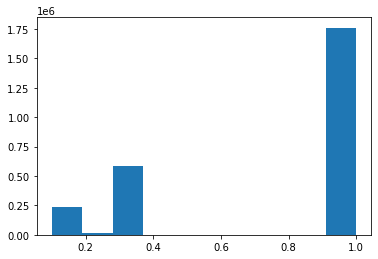

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.race == 1) & (X_train_orig.DI == 1)] = 0.3
    p[(X_train_orig.race == 0) & (X_train_orig.DI == 2)] = 0.1
    p[(X_train_orig.race == 0) & (X_train_orig.DI == 3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=1000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.2970171628721424
Initial TPR parity:  -0.2813381764941455
Initial predictive parity:  -0.1103973778729529
Initial loss:  0.3358081871407012
Initial accuracy:  0.8878985575244246


In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.15138217634571172
Initial accuracy:  0.8935367355482601


In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'race'
    parent_2 = 'race'
    parent_3 = 'DI'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

BF:  0.13701388095536116
AF:  0.2813381764941455
Test Acc:  0.8878985575244246
Test F1:  0.9398488979355327
Upper Bound: 0.6860355138778687
Lower Bound: -0.2158864140510559


### HDMA scenario 2

In [ ]:
indicator = ((dataset=='hmda') and (scenario==2))

**Sample based on the conditional probability**

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.income_brackets == 1) & (X_train_orig.DI == 1)] = 0.1
    p[(X_train_orig.income_brackets == 1) & (X_train_orig.DI == 2)] = 0.1
    p[(X_train_orig.income_brackets == 0) & (X_train_orig.DI == 3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'income_brackets'
    parent_2 = 'income_brackets'
    parent_3 = 'DI'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 3

In [ ]:
indicator = ((dataset=='hmda') and (scenario==3))

**Sample based on the conditional probability**

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(y_train == 1) & (X_train_orig.LV == 1)] = 0.05
    p[(y_train == 0) & (X_train_orig.LV == 1)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'LV'
    parent_2 = 'LV'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 4

In [ ]:
indicator = ((dataset=='hmda') and (scenario==4))

**Sample based on the conditional probability**

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.race==0)&(X_train_orig.DI==1)] = 0.2
    p[(X_train_orig.race==0)&(X_train_orig.DI==2)] = 0.3
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'race'
    parent_2 = 'race'
    parent_3 = 'DI'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 5

In [ ]:
indicator = ((dataset=='hmda') and (scenario==5))

**Sample based on the conditional probability**

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.income_brackets == 1) & (X_train_orig.DI == 1)] = 0.1
    p[(X_train_orig.income_brackets == 0) & (X_train_orig.DI == 2)] = 0.1
    p[(X_train_orig.income_brackets == 1) & (X_train_orig.DI == 3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'income_brackets'
    parent_2 = 'income_brackets'
    parent_3 = 'DI'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 6

In [ ]:
indicator = ((dataset=='hmda') and (scenario==6))

**Sample based on the conditional probability**

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(y_train == 1) & (X_train_orig.DI == 1)] = 0.5
    p[(y_train == 1) & (X_train_orig.DI == 2)] = 0.5
    p[(y_train == 0) & (X_train_orig.DI == 3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'DI'
    parent_2 = 'DI'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### HDMA scenario 7

In [ ]:
indicator = ((dataset=='hmda') and (scenario==7))

In [ ]:
if indicator:
    data = pd.read_csv('races_White-Black or African American_loan_purposes_1_year_2019.csv')

In [ ]:
# if indicator:
#     tbar = tqdm.tqdm(total=53)
#     spds = []
#     accs = []
#     tprs = []

#     for state in data.state_code.unique()[~pd.isna(data.state_code.unique())]:
#         df = data[data['state_code']==state].reset_index(drop=True)
#     #     df = pd.read_csv('state_CO_races_White-Black or African American_loan_purposes_1.csv')
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [ ]:
# if indicator:
#     state = 'LA'
#     df = data[data['state_code']==state].reset_index(drop=True)
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1})
#     df.dropna(inplace=True)
#     df['applicant_age'] = df['applicant_age'].astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'], errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.ones_like(df['loan_to_value_ratio'])
#     df['LV'][df['loan_to_value_ratio']<90] = 0
# #     bins = np.array([0, 90, 100])
# #     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     bins = np.array([0, 30, 60, 90])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
# #     df['income_brackets'] = np.digitize(df['income'], bins)
#     df['income_brackets'] = np.ones_like(df['income'])
#     df['income_brackets'][df['income']<100] = 0

#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

#     print(f'--------------- STATE: {state} ---------------')

#     clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=1000, c=0.003)

#     clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#     y_pred_test = clf.predict_proba(X_test)
#     y_pred_train = clf.predict_proba(X_train)

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)
    
#     f1_0 = computeF1(y_test, y_pred_test)
#     print("Initial F1: ", f1_0)
    
#     auc_0 = computeAUC(y_test, y_pred_test)
#     print("Initial AUC: ", auc_0)

In [ ]:
if indicator:
    txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
    cc = '22071'
    county, state = re.findall(f'<td>{cc}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
    df = data[data['county_code']==int(cc)].reset_index(drop=True)
    county, state = re.findall(f'<td>{cc}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
    df = df[(df.action_taken==1) | (df.action_taken==3)]
    w_idx = df[(df['applicant_race-1']==5)
               &(pd.isna(df['applicant_race-2']))
               &(df['applicant_ethnicity-1']==2)].index
    b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
    df['race'] = -1
    df['race'].loc[w_idx] = 1
    df['race'].loc[b_idx] = 0
    df = df[df['race']>=0]
    df = df[df['debt_to_income_ratio']!='Exempt']
    df['gender'] = -1
    df['gender'][df['applicant_sex']==1] = 1
    df['gender'][df['applicant_sex']==2] = 0
    df = df[df['gender']>=0]

    df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
             'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

    df['income'].fillna(71, inplace=True)
    df['loan_to_value_ratio'].fillna(93, inplace=True)
    df['debt_to_income_ratio'].fillna(41, inplace=True)

    df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
                                                   '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
    df = df[df['applicant_age']>=0]

    df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
    bins = np.array([40, 60, 79, 81, 90, 100])
    df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

    df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
    df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
    df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
    df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
    df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
    df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
    bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
    df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

    bins = np.array([32, 53, 107, 374])
    df['income_brackets'] = np.digitize(df['income'], bins)

    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    df['action_taken'][df['action_taken']==3] = 0

    y = df['action_taken']
    df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
    X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
    X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    X_train.to_csv(f'hmda_{county}_X_train.csv', index=False)
    X_test.to_csv(f'hmda_{county}_X_test.csv', index=False)
    y_train.to_csv(f'hmda_{county}_y_train.csv', index=False)
    y_test.to_csv(f'hmda_{county}_y_test.csv', index=False)

In [ ]:
if indicator:
    txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
    cc = '22071'
    df = data[data['county_code']==int(cc)].reset_index(drop=True)
    county, state = re.findall(f'<td>{cc}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
    df = df[(df.action_taken==1) | (df.action_taken==3)]
    w_idx = df[(df['applicant_race-1']==5)
               &(pd.isna(df['applicant_race-2']))
               &(df['applicant_ethnicity-1']==2)].index
    b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
    df['race'] = -1
    df['race'].loc[w_idx] = 1
    df['race'].loc[b_idx] = 0
    df = df[df['race']>=0]
    df = df[df['debt_to_income_ratio']!='Exempt']
    df['gender'] = -1
    df['gender'][df['applicant_sex']==1] = 1
    df['gender'][df['applicant_sex']==2] = 0
    df = df[df['gender']>=0]

    df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
             'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

    df['income'].fillna(71, inplace=True)
    df['loan_to_value_ratio'].fillna(93, inplace=True)
    df['debt_to_income_ratio'].fillna(41, inplace=True)

    df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
                                                   '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
    df = df[df['applicant_age']>=0]

    df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
    bins = np.array([40, 60, 79, 81, 90, 100])
    df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

    df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
    df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
    df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
    df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
    df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
    df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
    bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
    df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

    bins = np.array([32, 53, 107, 374])
    df['income_brackets'] = np.digitize(df['income'], bins)

    df.dropna(inplace=True)
    df = df.reset_index(drop=True)
    df['action_taken'][df['action_taken']==3] = 0

    y = df['action_taken']
    df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
    X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
    X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    #         from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    y_pred_test = clf.predict_proba(X_test)
    
    print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
# if indicator:
#     print(df[(df['race']==0)].applicant_age.value_counts()/df[(df['race']==1)].applicant_age.value_counts())

In [ ]:
if indicator:
    ls = [34.8, 53.2, 48.6*1000, 39.6, 48.7, 33.1*1000, 39.3, 50.0, 37.5*1000, 25.4, 63.8, 29.2*1000, 24.8, 65.7, 9862]
    privs = [ls[3*i] for i in range(len(ls)//3)]
    prots = [ls[3*i+1] for i in range(len(ls)//3)]
    totals = [ls[3*i+2] for i in range(len(ls)//3)]

    privs_sum0 = 0
    prots_sum0 = 0
    for i in range(len(privs)):
        privs_sum0 += totals[i]*privs[i]
        prots_sum0 += totals[i]*prots[i]

    print(prots_sum0, privs_sum0)

In [ ]:
if indicator:
    ls = [32.3, 60.7, 49.9*1000, 31.2, 59.9, 49.4*1000]
    privs = [ls[3*i] for i in range(len(ls)//3)]
    prots = [ls[3*i+1] for i in range(len(ls)//3)]
    totals = [ls[3*i+2] for i in range(len(ls)//3)]

    privs_sum1 = 0
    prots_sum1 = 0
    for i in range(len(privs)):
        privs_sum1 += totals[i]*privs[i]
        prots_sum1 += totals[i]*prots[i]

    print(prots_sum1, privs_sum1)

In [ ]:
if indicator:
    print('Age distrib. (black):')
    print(prots_sum0/(prots_sum0+prots_sum1), prots_sum1/(prots_sum0+prots_sum1))
    print('Age distrib. (white):')
    print(privs_sum0/(privs_sum0+privs_sum1), privs_sum1/(privs_sum0+privs_sum1))

In [ ]:
if indicator:
    print('Age distrib. (black):')
    print(df[(df['race']==0)].applicant_age.value_counts()/len(df[(df['race']==0)]))
    print('Age distrib. (white):')
    print(df[(df['race']==1)].applicant_age.value_counts()/len(df[(df['race']==1)]))

In [ ]:
if indicator:
    ls = [34.8, 53.2, 48.6*1000, 39.6, 48.7, 33.1*1000, 39.3, 50.0, 37.5*1000, 25.4, 63.8, 29.2*1000, 24.8, 65.7, 9862]
    privs = [ls[3*i] for i in range(len(ls)//3)]
    prots = [ls[3*i+1] for i in range(len(ls)//3)]
    totals = [ls[3*i+2] for i in range(len(ls)//3)]

    privs_sum0 = 0
    prots_sum0 = 0
    for i in range(len(privs)):
        privs_sum0 += totals[i]*privs[i]
        prots_sum0 += totals[i]*prots[i]

    print(prots_sum0, privs_sum0)

In [ ]:
if indicator:
    ls = [72.6, 22.9, 25.2*1000, 71.6, 23.6, 25.5*1000]
    privs = [ls[3*i] for i in range(len(ls)//3)]
    prots = [ls[3*i+1] for i in range(len(ls)//3)]
    totals = [ls[3*i+2] for i in range(len(ls)//3)]

    privs_sum1 = 0
    prots_sum1 = 0
    for i in range(len(privs)):
        privs_sum1 += totals[i]*privs[i]
        prots_sum1 += totals[i]*prots[i]

    print(prots_sum1, privs_sum1)

In [ ]:
if indicator:
    print('Age distrib. (black):')
    print(prots_sum0/(prots_sum0+prots_sum1), prots_sum1/(prots_sum0+prots_sum1))
    print('Age distrib. (white):')
    print(privs_sum0/(privs_sum0+privs_sum1), privs_sum1/(privs_sum0+privs_sum1))

In [ ]:
if indicator:
    print('Age distrib. (black):')
    print(df[(df['race']==0)].applicant_age.value_counts()/len(df[(df['race']==0)]))
    print('Age distrib. (white):')
    print(df[(df['race']==1)].applicant_age.value_counts()/len(df[(df['race']==1)]))

In [ ]:
# if indicator:
#     cc = '06067'
#     top_counties = list(data[data['state_code']=='LA'].county_code.value_counts().iloc[:20].to_dict().keys())
#     top_counties = [str(int(c)) for c in top_counties]
#     txt = os.popen(f'curl https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697').read()
#     spds = []
#     accs = []
#     tprs = []
#     tbar = tqdm.tqdm(total=20)

#     for c in top_counties:
#         county, state = re.findall(f'<td>{"0"*(5-len(c))+c}</td>\n\t\t\t<td>(.+)</td>\n\t\t\t<td>(.+)</td>', txt)[0]
#         df = data[data['county_code']==float(c)].reset_index(drop=True)
#         df = df[(df.action_taken==1) | (df.action_taken==3)]
#         w_idx = df[(df['applicant_race-1']==5)
#                    &(pd.isna(df['applicant_race-2']))
#                    &(df['applicant_ethnicity-1']==2)].index
#         b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#         df['race'] = -1
#         df['race'].loc[w_idx] = 1
#         df['race'].loc[b_idx] = 0
#         df = df[df['race']>=0]
#         df = df[df['debt_to_income_ratio']!='Exempt']
#         df['gender'] = -1
#         df['gender'][df['applicant_sex']==1] = 1
#         df['gender'][df['applicant_sex']==2] = 0
#         df = df[df['gender']>=0]

#         df = df[['action_taken', 'income', 'race', 'gender', 'loan_type',
#                  'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#         df['income'].fillna(71, inplace=True)
#         df['loan_to_value_ratio'].fillna(93, inplace=True)
#         df['debt_to_income_ratio'].fillna(41, inplace=True)

#         df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#         bins = np.array([40, 60, 79, 81, 90, 100])
#         df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#         df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#         df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#         df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#         df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#         df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#         # df.loc[df['debt_to_income_ratio']=='Exempt', 'debt_to_income_ratio'] = -1
#         df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#         bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#         df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#         bins = np.array([32, 53, 107, 374])
#         df['income_brackets'] = np.digitize(df['income'], bins)

#         df.dropna(inplace=True)
#         df = df.reset_index(drop=True)
#         df['action_taken'][df['action_taken']==3] = 0

#         y = df['action_taken']
#         df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#         X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#         X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#         X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#         y_train = y_train.reset_index(drop=True)
#         y_test = y_test.reset_index(drop=True)

#         from sklearn.preprocessing import StandardScaler
#         sc = StandardScaler()
#         X_train = sc.fit_transform(X_train)
#         X_test = sc.transform(X_test)

#         print(f'--------------- STATE: {state} - COUNTY: {county} - POPULATION: {len(y)} ---------------')

#         clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#         clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#         y_pred_test = clf.predict_proba(X_test)
#         y_pred_train = clf.predict_proba(X_train)

#         spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#         print("Initial statistical parity: ", spd_0)

#         tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#         print("Initial TPR parity: ", tpr_parity_0)

#         accuracy_0 = computeAccuracy(y_test, y_pred_test)
#         print("Initial accuracy: ", accuracy_0)

#         spds.append(spd_0)
#         tprs.append(tpr_parity_0)
#         accs.append(accuracy_0)
#         tbar.update()

In [ ]:
# if indicator:
#     state = 'LA'
#     df = data[data['state_code']==state].reset_index(drop=True)
#     df = df[(df.action_taken==1) | (df.action_taken==3)]
#     w_idx = df[(df['applicant_race-1']==5)
#                &(pd.isna(df['applicant_race-2']))
#                &(df['applicant_ethnicity-1']==2)].index
#     b_idx = df[(df['applicant_race-1']==3)& (pd.isna(df['applicant_race-2']))].index
#     df['race'] = -1
#     df['race'].loc[w_idx] = 1
#     df['race'].loc[b_idx] = 0
#     df = df[df['race']>=0]
#     df = df[df['debt_to_income_ratio']!='Exempt']
#     df['gender'] = -1
#     df['gender'][df['applicant_sex']==1] = 1
#     df['gender'][df['applicant_sex']==2] = 0
#     df = df[df['gender']>=0]

#     df = df[['action_taken', 'income', 'race', 'gender', 'loan_type', 'applicant_age',
#              'debt_to_income_ratio', 'loan_to_value_ratio', 'lien_status']]

#     df['income'].fillna(71, inplace=True)
#     df['loan_to_value_ratio'].fillna(93, inplace=True)
#     df['debt_to_income_ratio'].fillna(41, inplace=True)

#     df['applicant_age'] = df['applicant_age'].map({'25-34': 0, '35-44': 0, '<25': 0, '8888': -1,
#                                                    '45-54': 1, '55-64': 1, '65-74': 1, '>74': 1}).astype(int)
#     df = df[df['applicant_age']>=0]

#     df['loan_to_value_ratio']= pd.to_numeric(df['loan_to_value_ratio'],errors= 'coerce')
#     bins = np.array([40, 60, 79, 81, 90, 100])
#     df['LV'] = np.digitize(df['loan_to_value_ratio'], bins)

#     df.loc[df['debt_to_income_ratio']=='<20%', 'debt_to_income_ratio'] = 15
#     df.loc[df['debt_to_income_ratio']=='20%-<30%', 'debt_to_income_ratio'] = 25
#     df.loc[df['debt_to_income_ratio']=='30%-<36%', 'debt_to_income_ratio'] = 33
#     df.loc[df['debt_to_income_ratio']=='50%-60%', 'debt_to_income_ratio'] = 55
#     df.loc[df['debt_to_income_ratio']=='>60%', 'debt_to_income_ratio'] = 65
#     df['debt_to_income_ratio'] = pd.to_numeric(df['debt_to_income_ratio'])
#     bins = np.array([0, 20, 30, 36, 40, 45, 50, 60])
#     df['DI'] = np.digitize(df['debt_to_income_ratio'], bins)

#     bins = np.array([32, 53, 107, 374])
#     df['income_brackets'] = np.digitize(df['income'], bins)

#     df.dropna(inplace=True)
#     df = df.reset_index(drop=True)
#     df['action_taken'][df['action_taken']==3] = 0

#     y = df['action_taken']
#     df = df.drop(columns=['action_taken', 'income', 'debt_to_income_ratio', 'loan_to_value_ratio'])
#     X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
#     X_train_orig = copy.deepcopy(X_train).reset_index(drop=True)
#     X_test_orig = copy.deepcopy(X_test).reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
#     y_test = y_test.reset_index(drop=True)

#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     X_train = sc.fit_transform(X_train)
#     X_test = sc.transform(X_test)

#     print(f'--------------- STATE: {state} ---------------')

#     clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

#     clf.fit(X_train, y_train.to_numpy(), use_sklearn=False)

#     y_pred_test = clf.predict_proba(X_test)
#     y_pred_train = clf.predict_proba(X_train)

#     spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
#     print("Initial statistical parity: ", spd_0)

#     tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
#     print("Initial TPR parity: ", tpr_parity_0)

#     accuracy_0 = computeAccuracy(y_test, y_pred_test)
#     print("Initial accuracy: ", accuracy_0)

### HDMA scenario 8

In [ ]:
indicator = ((dataset=='hmda') and (scenario==8))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.race).astype(float)
    p[(X_train_orig.race == 1) & (X_train_orig.applicant_age == 0)] = 0.1
    p[(X_train_orig.race == 0) & (X_train_orig.applicant_age == 0)] = 0.9
    plt.hist(p, bins=10)
    plt.show()

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=1000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'race'
    parent_1 = 'applicant_age'
    parent_2 = 'race'
    parent_3 = 'race'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 1

In [ ]:
indicator = ((dataset=='adult') and (scenario==1))

**Pr(C=1|married,female)=1, Pr(C=1|not_married,high)=1, Pr(C=1|married,male)=0.11, Pr(C=1|not_married,low)=1**

In [ ]:
# generate Pr(C=1|gender, income) for each training data point
if indicator:
    p = np.where(np.logical_and(X_train_orig.relationship, X_train_orig.gender), 0.11, 1.0)
    plt.hist(p)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'gender'
    parent_3 = 'gender'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 2


In [ ]:
indicator = ((dataset=='adult') and (scenario==2))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==1)&(X_train_orig.education==0)] = 0.2
    p[(X_train_orig.relationship==1)&(X_train_orig.education==1)] = 0.4
    p[(X_train_orig.relationship==1)&(X_train_orig.education==2)] = 0.6
    p[(X_train_orig.relationship==0)&(X_train_orig.education==1)] = 0.6
    p[(X_train_orig.relationship==0)&(X_train_orig.education==2)] = 0.4
    p[(X_train_orig.relationship==0)&(X_train_orig.education==3)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'relationship'
    parent_3 = 'education'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 3

In [ ]:
indicator = ((dataset=='adult') and (scenario==3))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==1)&(y_train==0)] = 0.2
    p[(X_train_orig.relationship==0)&(y_train==1)] = 0.2
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'relationship'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 4

In [ ]:
indicator = ((dataset=='adult') and (scenario==4))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==0)&(X_train_orig.gender==1)] = 0.5
    plt.hist(p)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'gender'
    parent_2 = 'gender'
    parent_3 = 'relationship'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 5

In [ ]:
indicator = ((dataset=='adult') and (scenario==5))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==0)&(X_train_orig.hours==0)] = 0.154/0.658
    p[(X_train_orig.relationship==1)&(X_train_orig.hours==1)] = 0.240/1.52
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'relationship'
    parent_3 = 'hours'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Adult scenario 6

In [ ]:
indicator = ((dataset=='adult') and (scenario==6))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.gender).astype(float)
    p[(X_train_orig.relationship==1)&(y_train==1)] = 0.7
    p[(X_train_orig.relationship==0)&(y_train==0)] = 0.6
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled.to_numpy(), use_sklearn=False)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'gender'
    parent_1 = 'relationship'
    parent_2 = 'relationship'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 1

In [ ]:
indicator = ((dataset=='law') and (scenario==1))

In [ ]:
if indicator:
    plt.figure(figsize=(4, 4))
    plt.ylabel('Num. of points')
    numerators = []
    denominators = []
    ratios = []
    for u in range(2):
        for v in range(2):
            numerator = len(X_train_orig[(X_train_orig.racetxt==1)&(X_train_orig.decile3==u)&(X_train_orig.lsat==v)].index)
            denominator = len(X_train_orig[(X_train_orig.racetxt==0)&(X_train_orig.decile3==u)&(X_train_orig.lsat==v)].index)
            numerators.append(numerator)
            denominators.append(denominator)
            ratio = numerator/denominator
            ratios.append(ratio)

    plt.bar(range(4), numerators, alpha=0.5, label='white')
    plt.bar(range(4), denominators, alpha=0.5, label='non-white')
    plt.xticks(range(4), [round(r, 2) for r in ratios])
    plt.legend()
    plt.xlabel('decile3+lsat (divided by race)')

In [ ]:
# generate Pr(C=1|race, decile3, lsat) for each training data point
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
#     p[(X_train_orig.racetxt==0)&(X_train_orig.decile3==0)&(X_train_orig.lsat==0)] = ratios[0]/ratios[2]
#     p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==0)&(X_train_orig.lsat==1)] = ratios[2]/ratios[1]
#     p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==1)&(X_train_orig.lsat==1)] = ratios[2]/ratios[3]
    p[(X_train_orig.racetxt==0)&(X_train_orig.decile3==0)] = 0.2
    p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==1)] = 0.5
#     p[(X_train_orig.racetxt==1)&(X_train_orig.decile3==1)&(X_train_orig.lsat==1)] = ratios[2]/ratios[3]
    
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'decile3'
    parent_2 = 'decile3'
    parent_3 = 'racetxt'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 2

In [ ]:
indicator = ((dataset=='law') and (scenario==2))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==1)&(X_train_orig.decile3==0)] = 0.1
    p[(X_train_orig.lsat==0)&(X_train_orig.decile3==1)] = 0.3
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'decile3'
    parent_2 = 'decile3'
    parent_3 = 'lsat'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 3

In [ ]:
indicator = ((dataset=='law') and (scenario==3))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==1)&(y_train==1)] = 0.1
    p[(X_train_orig.lsat==0)&(y_train==0)] = 0.7
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'lsat'
    parent_2 = 'lsat'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)
    spd_0 = computeFairness(clf.predict_proba(X_train_sampled), X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("BF: ", -spd_0)
    y_pred_train = clf.predict_proba(X_train)
    spd_0 = computeFairness(clf.predict_proba(X_train), X_train_orig, y_train, 0, dataset)
    print("AF: ", -spd_0)

    # Group the training data based on parent (sensitive attr=0)
    protected_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==0)].index
            if len(idx)>0:
                protected_groups.append(idx)

    score_protected_groups = []
    for idx in protected_groups:
        score_protected_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    # Group the training data based on parent (sensitive attr=1)
    privileged_groups = []
    for v in np.sort(X_train_orig_sampled[parent_1].unique()):
        for u in np.sort(X_train_orig_sampled[parent_2].unique()):
            idx = X_train_orig_sampled[(X_train_orig_sampled[parent_1]==v) &\
                                       (X_train_orig_sampled[parent_2]==u) &\
                                       (X_train_orig_sampled[sens_attr]==1)].index
            if len(idx)>0:
                privileged_groups.append(idx)

    score_privileged_groups = []
    for idx in privileged_groups:
        score_privileged_groups.append(np.mean(clf.predict_proba(X_train_sampled)[idx]))

    print(f'Upper Bound: {np.max(score_privileged_groups)-np.min(score_protected_groups)}')
    print(f'Lower Bound: {-np.max(score_protected_groups)+np.min(score_privileged_groups)}')

### Law scenario 4

In [ ]:
indicator = ((dataset=='law') and (scenario==4))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.racetxt == 1) & (X_train_orig.decile3 == 0) & (X_train_orig.lsat == 0)] = 0.5
    p[(X_train_orig.racetxt == 0) & (X_train_orig.decile3 == 0) & (X_train_orig.lsat == 1)] = 0.3
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'decile3'
    parent_2 = 'lsat'
    parent_3 = 'racetxt'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 5

In [ ]:
indicator = ((dataset=='law') and (scenario==5))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==0)&(X_train_orig.ugpa==0)] = 0.7/5.71
    p[(X_train_orig.lsat==1)&(X_train_orig.ugpa==1)] = 5/11.48
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'ugpa'
    parent_2 = 'ugpa'
    parent_3 = 'lsat'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

### Law scenario 6

In [ ]:
indicator = ((dataset=='law') and (scenario==6))

In [ ]:
if indicator:
    p = np.ones_like(X_train_orig.racetxt).astype(float)
    p[(X_train_orig.lsat==0)&(y_train==1)] = 0.5
    p[(X_train_orig.lsat==1)&(y_train==0)] = 0.7
    plt.hist(p, bins=10)
    plt.show()

**Sample based on the conditional probability**

In [ ]:
if indicator:
    np.random.seed(0)
    sample_bool = np.zeros(len(X_train))
    for idx in range(len(X_train)):
        sample_bool[idx] = np.random.binomial(n=1, p=p[idx])  # True or False

In [ ]:
if indicator:
    X_train_orig_sampled = X_train_orig.loc[np.where(sample_bool)[0]]
    X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
    X_train_sampled = X_train[np.where(sample_bool)[0]]
    y_train_sampled = y_train[np.where(sample_bool)[0]].reset_index(drop=True)

In [ ]:
if indicator:
    clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=3000, c=0.003)

    clf.fit(X_train_sampled, y_train_sampled)

    y_pred_test = clf.predict_proba(X_test)
    y_pred_train = clf.predict_proba(X_train)

    spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Initial TPR parity: ", tpr_parity_0)

    predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
    print("Initial predictive parity: ", predictive_parity_0)

    loss_0 = logistic_loss(y_test, y_pred_test)
    print("Initial loss: ", loss_0)

    accuracy_0 = computeAccuracy(y_test, y_pred_test)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    y_pred_train = clf.predict_proba(X_train_sampled)

    spd_0 = computeFairness(y_pred_train, X_train_orig_sampled, y_train_sampled, 0, dataset)
    print("Initial statistical parity: ", spd_0)

    accuracy_0 = computeAccuracy(y_train_sampled, y_pred_train)
    print("Initial accuracy: ", accuracy_0)

In [ ]:
if indicator:
    sens_attr = 'racetxt'
    parent_1 = 'lsat'
    parent_2 = 'lsat'
    parent_3 = 'y'

**Bound**

In [ ]:
if indicator:
    record_statistics(clf, record=False)

## Regularizer

In [ ]:
BFs = []
AFs = []
ubs = []
lbs = []
accs = []
f1s = []

### Prepare Validation Set

In [ ]:
X_train_orig_sampled, X_val_orig_sampled, y_train_sampled, y_val_sampled = \
    train_test_split(X_train_orig_sampled, y_train_sampled, test_size=0.25, random_state=val_seed)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sampled = sc.fit_transform(X_train_orig_sampled)
X_val_sampled = sc.transform(X_val_orig_sampled)
X_train_orig_sampled = X_train_orig_sampled.reset_index(drop=True)
X_val_orig_sampled = X_val_orig_sampled.reset_index(drop=True)
y_train_sampled = y_train_sampled.reset_index(drop=True)
y_val_sampled = y_val_sampled.reset_index(drop=True)
X_test = sc.transform(X_test_orig)
X_train = sc.transform(X_train_orig)

### No Regularizer

In [ ]:
epoch_num=300

In [ ]:
info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

In [ ]:
clf = LogisticRegression(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict=info_dict)

# y_pred_test = clf.predict_proba(X_test)
# y_pred_train = clf.predict_proba(X_train)

# spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
# print("Initial statistical parity: ", spd_0)

# tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
# print("Initial TPR parity: ", tpr_parity_0)

# predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
# print("Initial predictive parity: ", predictive_parity_0)

# loss_0 = logistic_loss(y_test, y_pred_test)
# print("Initial loss: ", loss_0)

# accuracy_0 = computeAccuracy(y_test, y_pred_test)
# print("Initial accuracy: ", accuracy_0)
# # accs.append(accuracy_0)

Best Threshold=0.579597, G-mean=0.948


In [ ]:
record_statistics(clf)

BF:  0.12474028248314295
AF:  0.27933791989979695
Test Acc:  0.8884400435034758
Test F1:  0.9401175008566911
Upper Bound: 0.7313617467880249
Lower Bound: -0.2839183211326599


### Bound Regularizer

In [ ]:
info_dict = dict()
info_dict['th'] = th
info_dict['balance'] = 1
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

In [ ]:
clf = LogisticRegression_Reg_Bound(input_size=X_train.shape[-1], epoch_num=100, c=c)

clf = train_clf(clf, info_dict)

# y_pred_test = clf.predict_proba(X_test)

# spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
# print("Initial statistical parity: ", spd_0)

# tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
# print("Initial TPR parity: ", tpr_parity_0)

# predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
# print("Initial predictive parity: ", predictive_parity_0)

# loss_0 = logistic_loss(y_test, y_pred_test)
# print("Initial loss: ", loss_0)

# accuracy_0 = computeAccuracy(y_test, y_pred_test)
# print("Initial accuracy: ", accuracy_0)
# # accs.append(accuracy_0)

Best Threshold=0.788934, G-mean=0.942


In [ ]:
record_statistics(clf)

BF:  -0.011759799741643984
AF:  -0.002059243250829401
Test Acc:  0.8842835232892812
Test F1:  0.9385886066080334
Upper Bound: 0.015855491161346436
Lower Bound: -0.019511282444000244


### Metric Regularizer

In [ ]:
info_dict = dict()
info_dict['th'] = 0
info_dict['balance'] = 1
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
privileged_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
info_dict['train_regularizer'] = [protected_idx, privileged_idx]

protected_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
privileged_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
info_dict['val_regularizer'] = [protected_idx, privileged_idx]

In [ ]:
clf = LogisticRegression_Reg_Metric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

KeyboardInterrupt: 

In [ ]:
record_statistics(clf)

### Weighted Metric Regularizer

In [ ]:
info_dict = dict()
info_dict['th'] = 0
info_dict['balance'] = 6
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

weights = [[], []]
for s in range(2):
    s_idx = X_train_orig[X_train_orig[sens_attr]==s].index.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig[(get_attr(X_train_orig, y_train, parent_1)==v) &\
                                   (get_attr(X_train_orig, y_train, parent_2)==u) &\
                                   (get_attr(X_train_orig, y_train, parent_3)==w) &\
                                   (get_attr(X_train_orig, y_train, sens_attr)==s)].index
                idx = idx.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
                if len(idx)>0:
                    weights[s].append(len(idx)/len(s_idx))

# weights = [[0.636514, 0.363486], [0.589085, 0.410914]]
# weights = [[0.589058, 0.410942], [0.634008, 0.3659912]]
info_dict['weights'] = weights


0 0 1
0 0 2
0 0 3
1 1 1
1 1 2
1 1 3


In [ ]:
clf = LogisticRegression_Reg_WeightedMetric(input_size=X_train.shape[-1], epoch_num=100, c=c)

clf = train_clf(clf, info_dict)

# y_pred_test = clf.predict_proba(X_test)
# y_pred_train = clf.predict_proba(X_train)

# spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
# print("Initial statistical parity: ", spd_0)

# tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
# print("Initial TPR parity: ", tpr_parity_0)

# predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
# print("Initial predictive parity: ", predictive_parity_0)

# loss_0 = logistic_loss(y_test, y_pred_test)
# print("Initial loss: ", loss_0)

# accuracy_0 = computeAccuracy(y_test, y_pred_test)
# print("Initial accuracy: ", accuracy_0)
# # accs.append(accuracy_0)

Best Threshold=0.761457, G-mean=0.950


In [ ]:
record_statistics(clf)

### Est. Weighted Metric Regularizer (limited info)

In [ ]:
info_dict = dict()
extl_info = dict()
info_dict['th'] = 0.01
info_dict['balance'] = 2
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)

info_dict['train_regularizer'] = [protected_groups, privileged_groups]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_groups.append(idx)
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

extl_info['data'] = X_train
idxs = [[], []]
for s in range(2):
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
            for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
                idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                           (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==s)].index
                idx_unbiased = X_train_orig[(get_attr(X_train_orig, y_train, parent_1)==v) &\
                                            (get_attr(X_train_orig, y_train, parent_2)==u) &\
                                            (get_attr(X_train_orig, y_train, parent_3)==w) &\
                                            (get_attr(X_train_orig, y_train, sens_attr)==s)].index
                idx_a = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
                if len(idx_a)>0:
                    idxs[s].append(len(idx_a)/len(idx)*len(idx_unbiased))

weights = [[], []]
for s in range(2):
    weights[s] = [w/sum(idxs[s]) for w in idxs[s]]
info_dict['weights'] = weights

In [ ]:
clf = LogisticRegression_Reg_WeightedMetric(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
# accs.append(accuracy_0)

Initial statistical parity:  -0.02658192196480036
Initial TPR parity:  -0.026939236343843764
Initial predictive parity:  -0.06334431849403444
Initial loss:  0.411240998951979
Initial accuracy:  0.8514851485148515


In [ ]:
record_statistics(clf)

BF:  0.019124649632480728
AF:  0.026939236343843764
Test Acc:  0.8514851485148515
Test F1:  0.9142857142857144
Upper Bound: 0.037895798683166504
Lower Bound: 0.002000272274017334


### Cov Regularizer

In [ ]:
info_dict = dict()
info_dict['th'] = 0
info_dict['fair_metric'] = fair_metric
info_dict['balance'] = 8
info_dict['sens'] = X_train_orig_sampled[sens_attr].to_numpy()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()

protected_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
privileged_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
info_dict['train_regularizer'] = [protected_idx, privileged_idx]

protected_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
privileged_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
info_dict['val_regularizer'] = [protected_idx, privileged_idx]

In [ ]:
clf = LogisticRegression_Reg_Cov(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
# accs.append(accuracy_0)

Initial statistical parity:  -0.04388984562385656
Initial TPR parity:  -0.03096588574927195
Initial predictive parity:  -0.04574870657541785
Initial loss:  0.560022417359314
Initial accuracy:  0.6772277227722773


In [ ]:
record_statistics(clf)

BF:  -0.03202239518178018
AF:  0.03096588574927195
Test Acc:  0.6772277227722773
Test F1:  0.7852437417654808
Upper Bound: -0.009022057056427002
Lower Bound: -0.09561586380004883


### Adversarial Debiasing

In [ ]:
clf = LogisticRegression_AD(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c,
                            learning_rate=0.01, adv_learning_rate=0.2)
spds, accs_clf, acc_advs = clf.fit(X_train_sampled, y_train_sampled, X_train_orig_sampled[sens_attr],
                               th=0, balance=0.8, loss_balance=8, load=True)

TypeError: fit() missing 2 required positional arguments: 'fair_metric' and 'acc_metric'

In [ ]:
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

In [ ]:
# plt.plot(spds)

In [ ]:
# plt.plot(accs_clf)

In [ ]:
# plt.plot(acc_advs)

In [ ]:
record_statistics(clf)

### IPW

In [ ]:
positive_data = X_train[y_train==1]
positive_source = sample_bool[y_train==1]

all_data = X_train
all_source = sample_bool

In [ ]:
Pr_C_given_X = LogisticRegression(input_size=X_train.shape[-1])
Pr_C_given_X.fit(all_data, all_source.ravel())
print(computeAccuracy(all_source.ravel(), Pr_C_given_X.predict_proba(all_data)))
print(computeF1(all_source.ravel(), Pr_C_given_X.predict_proba(all_data)))

Pr_C_given_YX = LogisticRegression(input_size=positive_data.shape[-1])
Pr_C_given_YX.fit(positive_data, positive_source.ravel())
print(computeAccuracy(positive_source.ravel(), Pr_C_given_YX.predict_proba(positive_data)))
print(computeF1(positive_source.ravel(), Pr_C_given_YX.predict_proba(positive_data)))

In [ ]:
training_weights = Pr_C_given_X.predict_proba(X_train_sampled)/Pr_C_given_YX.predict_proba(X_train_sampled)
val_weights = Pr_C_given_X.predict_proba(X_val_sampled)/Pr_C_given_YX.predict_proba(X_val_sampled)

In [ ]:
info_dict = dict()
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()
info_dict['clf_numerator'] = Pr_C_given_X
info_dict['clf_denominator'] = Pr_C_given_YX
info_dict['th'] = th
info_dict['balance'] = 8

protected_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
privileged_idx = X_train_orig_sampled[X_train_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
info_dict['train_regularizer'] = [protected_idx, privileged_idx]

protected_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==0].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
privileged_idx = X_val_orig_sampled[X_val_orig_sampled[sens_attr]==1].index.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
info_dict['val_regularizer'] = [protected_idx, privileged_idx]

In [ ]:
clf = LogisticRegression_IPW(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)
clf = train_clf(clf, info_dict=info_dict)

In [ ]:
# y_pred_test = np.clip(clf.predict_proba(X_test)*Pr_C_given_X.predict_proba(X_test)/Pr_C_given_YX.predict_proba(X_test), 0, 1)
# y_pred_train = np.clip(clf.predict_proba(X_train)*Pr_C_given_X.predict_proba(X_train)/Pr_C_given_YX.predict_proba(X_train), 0, 1)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
# accs.append(accuracy_0)

In [ ]:
record_statistics(clf)

In [ ]:
y_pred_test = clf.predict_proba(X_test)
computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)

In [ ]:
plt.hist(training_weights)

In [ ]:
len(X_train_sampled)/len(X_train),\
len(training_weights[training_weights>=1])/len(training_weights[training_weights<1])

### Better Bound Regularizer

In [ ]:
info_dict = dict()
info_dict['th'] = th
info_dict['balance'] = 2
info_dict['x_train'] = X_train_sampled
info_dict['y_train'] = y_train_sampled.to_numpy()
info_dict['x_val'] = X_val_sampled
info_dict['y_val'] = y_val_sampled.to_numpy()
# info_dict['x_val'] = X_train_sampled
# info_dict['y_val'] = y_train_sampled.to_numpy()

protected_subgroup_idx = [[] for _ in range(len(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()))]
privileged_subgroup_idx = [[] for _ in range(len(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()))]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                protected_subgroup_idx[v].append(len(protected_groups))
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_train_orig_sampled[(get_attr(X_train_orig_sampled, y_train_sampled, parent_1)==v) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_2)==u) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, parent_3)==w) &\
                                       (get_attr(X_train_orig_sampled, y_train_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_train_orig_sampled, y_train_sampled, A, A_val))
            if len(idx)>0:
                privileged_subgroup_idx[v].append(len(privileged_groups))
                privileged_groups.append(idx)

info_dict['train_subgroup_idx'] = [protected_subgroup_idx, protected_subgroup_idx]
info_dict['train_regularizer'] = [protected_groups, privileged_groups]
# info_dict['val_subgroup_idx'] = [protected_subgroup_idx, privileged_subgroup_idx]
# info_dict['val_regularizer'] = [protected_groups, privileged_groups]

protected_subgroup_idx = [[] for _ in range(len(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()))]
privileged_subgroup_idx = [[] for _ in range(len(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()))]

protected_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==0)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                protected_subgroup_idx[v].append(len(protected_groups))
                protected_groups.append(idx)

privileged_groups = []
for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
    for u in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_2).unique()):
        for w in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_3).unique()):
            idx = X_val_orig_sampled[(get_attr(X_val_orig_sampled, y_val_sampled, parent_1)==v) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_2)==u) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, parent_3)==w) &\
                                       (get_attr(X_val_orig_sampled, y_val_sampled, sens_attr)==1)].index
            idx = idx.intersection(get_A_idx(X_val_orig_sampled, y_val_sampled, A, A_val))
            if len(idx)>0:
                privileged_subgroup_idx[v].append(len(privileged_groups))
                privileged_groups.append(idx)

info_dict['val_subgroup_idx'] = [protected_subgroup_idx, privileged_subgroup_idx]
info_dict['val_regularizer'] = [protected_groups, privileged_groups]

weights = [[], []]
for s in range(2):
    s_idx = X_train_orig[X_train_orig[sens_attr]==s].index.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
    for v in np.sort(get_attr(X_train_orig_sampled, y_train_sampled, parent_1).unique()):
        idx = X_train_orig[(get_attr(X_train_orig, y_train, parent_1)==v) &\
                           (get_attr(X_train_orig, y_train, sens_attr)==s)].index
        idx = idx.intersection(get_A_idx(X_train_orig, y_train, A, A_val))
        if len(idx)>0:
            weights[s].append(len(idx)/len(s_idx))
weights = [[0.589058, 0.410942], [0.634008, 0.3659912]]
info_dict['weights'] = weights


In [ ]:
clf = LogisticRegression_Reg_Tighter_Bound(input_size=X_train.shape[-1], epoch_num=epoch_num, c=c)

clf = train_clf(clf, info_dict)

y_pred_test = clf.predict_proba(X_test)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)
# accs.append(accuracy_0)

Best Threshold=0.755026, G-mean=0.941
Initial statistical parity:  -0.006502339346000752
Initial TPR parity:  -0.00880114259532394
Initial predictive parity:  -0.05268914705467442
Initial loss:  0.3127281553079325
Initial accuracy:  0.9051321928460342


In [ ]:
record_statistics(clf)

BF:  0.008183736874621705
AF:  0.00880114259532394
Test Acc:  0.9051321928460342
Test F1:  0.9501226492232215
Upper Bound: 0.01459437608718872
Lower Bound: -0.009451031684875488


## Record Results

In [ ]:
# rearange_idx = [0, 2, 5, 1, 3, 4]

In [ ]:
# plt.figure(figsize=(8, 5))
# plt.plot(range(len(AFs)), np.array(AFs)[rearange_idx], color='black', lw=3)
# plt.fill_between(range(len(AFs)), np.array(lbs)[rearange_idx], np.array(ubs)[rearange_idx], color='blue', alpha=0.5)
# plt.xticks(range(len(AFs)), np.array(['Orig', 'Bound Reg.', 'BF Reg.', 'AF Reg.', 'Est.AF Reg.', 'Adv. Debias'])[rearange_idx])
# plt.ylabel('EO' if fair_metric else 'SPD')
# plt.show()

In [ ]:
AFs, BFs, ubs, lbs, accs

In [ ]:
# dict_name = '_'
# if fair_metric == 1:
#     dict_name = 'EO' + dict_name
# elif fair_metric == 0:
#     dict_name = 'SPD' + dict_name
# else:
#     raise NotImplementedError

# if clf_name == 'LogisticRegression':
#     dict_name = dict_name + 'LR'
# elif clf_name == 'SVM':
#     dict_name = dict_name + 'SVM'
# elif clf_name == 'NeuralNetwork':
#     dict_name = dict_name + 'NN'
# else:
#     raise NotImplementedError

# dict_name = dict_name + '.dict'

# with open(dict_name, 'r') as f:
#     txt = f.read()
# d = json.loads(txt)
# name = ['Orig', 'Bound Reg.', 'BF Reg.', 'AF Reg.', 'Est.AF Reg.', 'Cov Reg.', 'Adv. Debias', 'IPW']
# for n_idx, n in enumerate(name):
#     if f'sc{scenario}' not in d[dataset]:
#         d[dataset][f'sc{scenario}'] = dict()
#         for vs in val_seeds:
#             d[dataset][f'sc{scenario}'][str(vs)] = dict()
#     d[dataset][f'sc{scenario}'][str(val_seed)][n] = [float(AFs[n_idx]), float(BFs[n_idx]),
#                                                      float(ubs[n_idx]), float(lbs[n_idx]), float(accs[n_idx])]
# txt = json.dumps(d)
# with open(dict_name, 'w+') as f:
#     f.write(txt)

In [ ]:
# for fm in ['EO', 'SPD']:
#     for mt in ['LR', 'SVM', 'NN']:
#         if (fm=='EO') and (mt=='LR'):
#             continue
#         else:
#             d = dict()
#             d['adult'] = dict()
#             d['law'] = dict()
#             d['hmda'] = dict()
#             for k in d.keys():
#                 d[k] = dict()
#                 for sc in range(1, 4):
#                     d[k][f'sc{sc}'] = dict()
#                     for seed in val_seeds:
#                         d[k][f'sc{sc}'][seed] = dict()
#             txt = json.dumps(d)

#             with open(f'{fm}_{mt}.dict', 'w+') as f:
#                 f.write(txt)
#                 f.close()

In [ ]:
# dict_name = 'SPD_LR.dict'
# with open(dict_name, 'r') as f:
#     txt = f.read()
#     d = json.loads(txt)
#     d['syn'] = dict()
#     d['syn'][f'sc1'] = dict()
#     for seed in val_seeds:
#         d['syn'][f'sc1'][seed] = dict()
#     txt = json.dumps(d)

In [ ]:
# with open(dict_name, 'w+') as f:
#     f.write(txt)
#     f.close()

In [ ]:
# df_dict = dict()
# df_dict[' '] = ['Orig', 'Reweighing', 'LFR', 'BF Reg.', 'Bound Reg.', 'AF Reg.', 'Est.AF Reg.']
# for ds in ['Adult', 'Law']:
#     for sc in range(1, 4):
#         df_dict[f'{ds} Scenario-{sc}'] = [round(d[ds.lower()][f'sc{sc}']['99'][method][0], 4) for method in df_dict[' ']]

In [ ]:
# pd.DataFrame(df_dict).to_latex()

In [ ]:
# print(pd.DataFrame(df_dict).to_latex(index=False))

In [ ]:
# d[ds.lower()][f'sc{sc}']['99']['BF Reg.']

In [ ]:
# fig = plt.figure(figsize=(8, 4), dpi=200)
# ax = plt.subplot(111)
# ax.set_facecolor('#E5E4E2')
# ax.grid(color='w', linestyle='solid')
# sc_dict = d['law'][f'sc{3}']['99']
# for i in range(len(df_dict[' '])):
#     m = df_dict[' '][i]
#     if i==0:
#         plt.errorbar(i, sc_dict[m][0], xerr=0.2, color='red', capthick=2, label='AF')
#         plt.errorbar(i, sc_dict[m][1], xerr=0.2, color='blue', capthick=2, label='BF')
#         plt.errorbar(i, (sc_dict[m][2]+sc_dict[m][3])/2,
#                      yerr=abs(sc_dict[m][2]-sc_dict[m][3])/2, color='black', elinewidth=1)
#         plt.errorbar(i, sc_dict[m][2], xerr=0.1, color='black', capthick=2, label='Bounds')
#         plt.errorbar(i, sc_dict[m][3], xerr=0.1, color='black', capthick=2)
#     else:
#         plt.errorbar(i, sc_dict[m][0], xerr=0.2, color='red', capthick=2)
#         plt.errorbar(i, sc_dict[m][1], xerr=0.2, color='blue', capthick=2)
#         plt.errorbar(i, (sc_dict[m][2]+sc_dict[m][3])/2,
#                      yerr=abs(sc_dict[m][2]-sc_dict[m][3])/2, color='black', elinewidth=1)
#         plt.errorbar(i, sc_dict[m][2], xerr=0.1, color='black', capthick=2)
#         plt.errorbar(i, sc_dict[m][3], xerr=0.1, color='black', capthick=2)

# # for spine in ax.spines.values():
# #     spine.set_visible(False)
# for spine in ax.spines.values():
#     spine.set_linewidth(2)
#     # spine.set_visible(False)

# ax.tick_params(top=False)
# ax.tick_params(right=False)
# ax.tick_params(labeltop=False)
# ax.tick_params(labelright=False)

# ax.xaxis.tick_bottom()
# ax.yaxis.tick_left()
# ax.set_axisbelow(True)

# ax.tick_params(colors='white', direction='out')
# for tick in ax.get_xticklabels():
#     tick.set_fontsize(12)
#     tick.set_color('black')
# for tick in ax.get_yticklabels():
#     tick.set_color('black')
#     tick.set_fontsize(12)

# ax.legend(fontsize=16, fancybox=False, framealpha=0)
# plt.tight_layout()
# plt.xticks(range(len(df_dict[' '])), df_dict[' '])
# # plt.savefig('scatter_debias.pdf', dpi=400)
# plt.show()

In [7]:
# name_mapping = {'Orig':'$ORIG$', 'Bound Reg.':'$C_{RAB}$-$B$', 'TightBound Reg.':'$C_{RAB}$-$MU$',
#                 'Adv. Debias':'$Z_{HANG}$', 'LFR':'$Z_{EMEL}$', 'Reweighing':'$K_{AMIRAN}$',
#                 'Cov. Reg.':'$Z_{AFAR}$', 'IPW':'$C_{ORTES}$', 'AF Reg.':'$C_{RAB}$-$C$',
#                 'Est.AF Reg.':'$C_{RAB}$-$MA$', 'BF Reg.':'BF', 'Test': '$Test$'}
# name_mapping = {'Orig':'$ORIG$', 'Bound Reg.':'CRAB-MX', 'TightBound Reg.':'$C_{RAB}$-$MU$',
#                 'Adv. Debias':'$Z_{HANG}$', 'LFR':'$Z_{EMEL}$', 'Reweighing':'$K_{AMIRAN}$',
#                 'Cov. Reg.':'$Z_{AFAR}$', 'IPW':'$C_{ORTES}$', 'AF Reg.':'$C_{RAB}$-$M\emptyset$',
#                 'Est.AF Reg.':'$C_{RAB}$-$MA$', 'BF Reg.':'BF', 'Test': '$Test$'}
name_mapping = {'Orig':'ORIG(SB)', 'Bound Reg.':'CRAB-MX', 'TightBound Reg.':'CRAB-MU',
                'Adv. Debias':'ZHANG', 'LFR':'ZEMEL', 'Reweighing':'KAMIRAN',
                'Cov. Reg.':'ZAFAR', 'IPW':'CORTES', 'AF Reg.':'CRAB-M$\emptyset$',
                'Est.AF Reg.':'CRAB-MA', 'BF Reg.':'BF', 'Test': 'ORIG(NOSB)'}
plot_alphabet = 'abcdefghijkl'
def get_name(x):
    if x in name_mapping:
        return name_mapping[x]
    else:
        base_name = x.split('-')[0]
        return name_mapping[base_name]
sc_mapping = {1:1, 4:2, 2:4, 5:3, 3:5, 6:6}

In [8]:
def single_scatter(ax, acc_mean, acc_std, spd_mean, spd_std, colors, methods, markers, title,
                   xlabel='Accuracy', ylabel='Statistical Parity', label_size=18, title_offset=-0.28,
                   title_size=16, legend_size=16, ticksize=12, markersize=75, eline_width=2):
#     ax.set_facecolor('#E5E4E2')
    for i in range(len(acc_mean)):
        ax.scatter(acc_mean[i], spd_mean[i], color=colors[i], linewidth=0, zorder=3,
                    edgecolor='black', label=get_name(methods[i]), s=markersize, marker=markers[i])
        ax.errorbar(acc_mean[i], spd_mean[i], xerr=acc_std[i], yerr=spd_std[i], color=colors[i],
                    ms=markersize, fmt='', elinewidth=eline_width, zorder=2)
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    for spine in ax.spines.values():
        spine.set_linewidth(1)
    ax.tick_params(top=False)
    ax.tick_params(right=False)
    ax.tick_params(labeltop=False)
    ax.tick_params(labelright=False)
#     ax.xaxis.set_major_formatter(FormatStrFormatter())

    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.set_axisbelow(True)

    ax.tick_params(colors='white', direction='out')
    for tick in ax.get_xticklabels():
        tick.set_fontsize(ticksize)
        tick.set_color('black')
    for tick in ax.get_yticklabels():
        tick.set_color('black')
        tick.set_fontsize(ticksize)
#     ax.legend(fontsize=legend_size, fancybox=False, framealpha=0.0)
    title = title
    ax.set_title(title, fontsize=title_size, y=title_offset)
    ax.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='x', nbins=4)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#     ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.3f'))
#     ax.figure.autofmt_xdate()

In [9]:
EO_STR = '$\digamma_{h, Y}(\Omega)$'
SPD_STR = '$\digamma_{h, \emptyset}(\Omega)$'

In [10]:
def plot_line(method, ds, sc, dict_name, ax, ths, label, color, marker, markersize=12, eline_width=2, err=False):
    with open(dict_name, 'r') as f:
        txt = f.read()
        d = json.loads(txt)
    test_afs = dict()
    test_accs = dict()
    methods = [f'{method}-{th}' for th in ths]
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    ax.plot(acc_mean, af_mean, label=get_name(label), color=color, marker=marker, markersize=markersize)
    if err:
        for i in range(len(acc_mean)):
            ax.errorbar(acc_mean[i], af_mean[i], xerr=acc_std[i], yerr=af_std[i], color=color,
                        ms=markersize, fmt='', elinewidth=eline_width)
#     if method=='Bound Reg.':
#         print(acc_mean)
    

In [11]:
# Bound
bound_th_dict = {'adult-1': [0.03, 0.15, 0.35, 0.43, 0.5], 'adult-4': [0.01, 0.06, 0.22, 0.3, 0.5],
                 'hmda-1': [0.2, 0.565, 0.69, 0.8, 1.0], 'hmda-4': [0.15, 0.235, 0.3, 0.4, 1.0],
                 'law-1': [0.05, 0.16, 0.24, 0.33, 0.5], 'law-4': [0.02, 0.12, 0.2, 0.35, 0.5]}

# Tight Bound
tightbound_th_dict = {'adult-2': [0.08, 0.13, 0.21, 0.28, 1.0], 'adult-5': [0.05, 0.12, 0.16, 0.23, 1.0],
                      'law-2': [0.05, 0.215, 0.265, 0.33, 1.0], 'law-5': [0.05, 0.22, 0.31, 0.39, 1.0],
                      'hmda-2': [0.01, 0.15, 0.28, 0.3, 1.0], 'hmda-5': [0.03, 0.455, 0.5, 0.52, 1.0]}

# Est
est_th_dict = {'adult-2': [0.01, 0.05, 0.10, 0.15, 0.25], 'adult-3': [0.02, 0.08, 0.16, 0.24, 0.4],
               'adult-5': [0.01, 0.05, 0.09, 0.13, 0.25], 'adult-6': [0.02, 0.08, 0.16, 0.24, 0.4],
               'law-2': [0.02, 0.08, 0.16, 0.24, 0.4], 'law-3': [0.05, 0.01, 0.09, 0.13, 0.25],
               'law-5': [0.02, 0.08, 0.16, 0.24, 0.4], 'law-6': [0.02, 0.08, 0.16, 0.24, 0.4],
               'hmda-2': [0.01, 0.04, 0.07, 0.1, 0.2], 'hmda-3': [0.02, 0.08, 0.16, 0.24, 0.4],
               'hmda-5': [0.01, 0.06, 0.11, 0.16, 0.3], 'hmda-6': [0.01, 0.05, 0.09, 0.13, 0.25]}

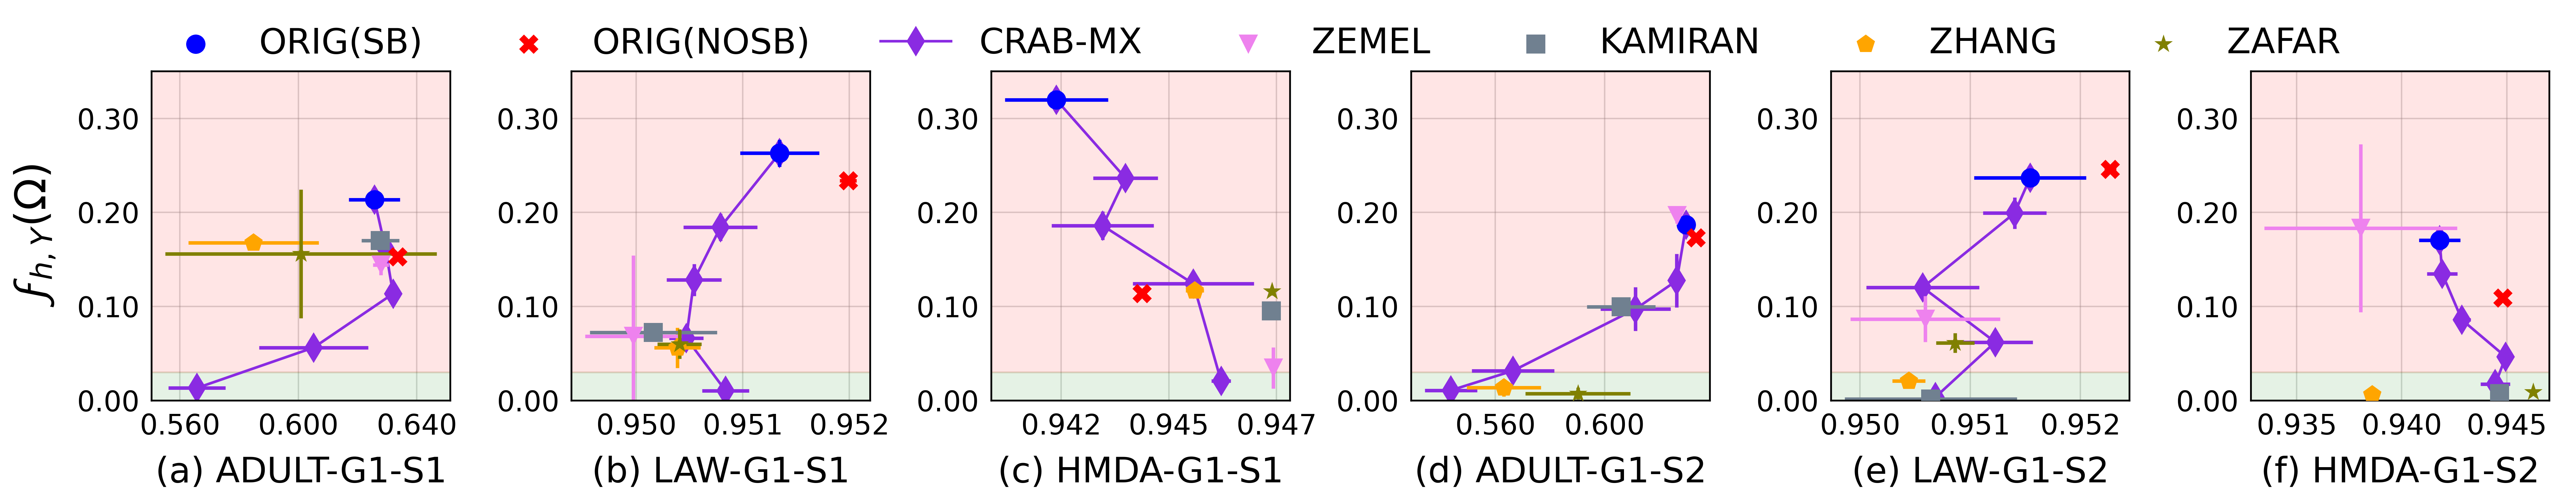

In [12]:
cnt = 0
fig, axs = plt.subplots(1, 6, dpi=400, figsize=(21, 4))
methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.', 'Test']
colors = ['blue', 'orange', 'violet', 'slategrey', 'olive', 'red']
markers = ['o', 'p', 'v', 's', '*', 'X']

for m in ['EO']:
    dict_name = m + '_LR.dict'
    with open(dict_name, 'r') as f:
        txt = f.read()
        d = json.loads(txt)
    for sc in [1, 4]:
        for ds in ['adult', 'law', 'hmda']:
            col_id = (cnt%6)
            row_id = (cnt//6)
            ax = axs[col_id]
            afs = dict()
            test_accs = dict()
            mts = []
            for method in methods:
                mt = method
                mts.append(mt)
                afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
                test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
            af_mean = [np.mean(afs[mt]) for mt in mts]
            acc_mean = [np.mean(test_accs[mt]) for mt in mts]
            af_std = [np.std(afs[mt]) for mt in mts]
            acc_std = [np.std(test_accs[mt]) for mt in mts]
            ylabel = None
            xlabel = None
            ths = bound_th_dict[f'{ds}-{sc}']
            plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
                      color='blueviolet', marker='d', markersize=10.95, err=True)
            single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, mts, markers,
                           f'({plot_alphabet[cnt]}) {ds.upper()}-G1-S{sc_mapping[sc]}', xlabel, ylabel, label_size=10,
                           title_size=20, legend_size=5, ticksize=16, markersize=120)
            ax.set_ylim(0, 0.35)
            xleft, xright = ax.get_xlim()
            ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
            ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
            ax.set_xlim(xleft, xright)
            ax.grid(color='grey', linestyle='-', alpha=0.3)
            ax.set_zorder(3)
            cnt += 1

lines, labels = axs[-1].get_legend_handles_labels()
order = [1, 6, 0, 3, 4, 2, 5]
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
                 fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
                 prop={'size': 20})
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [120]
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('\n\nF1-Score', fontsize=20)
plt.ylabel(f'{EO_STR}\n', fontsize=24)
# ax.xaxis.set_label_coords(0.5, -1)

plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/bounds-comparison.pdf', bbox_inches='tight')

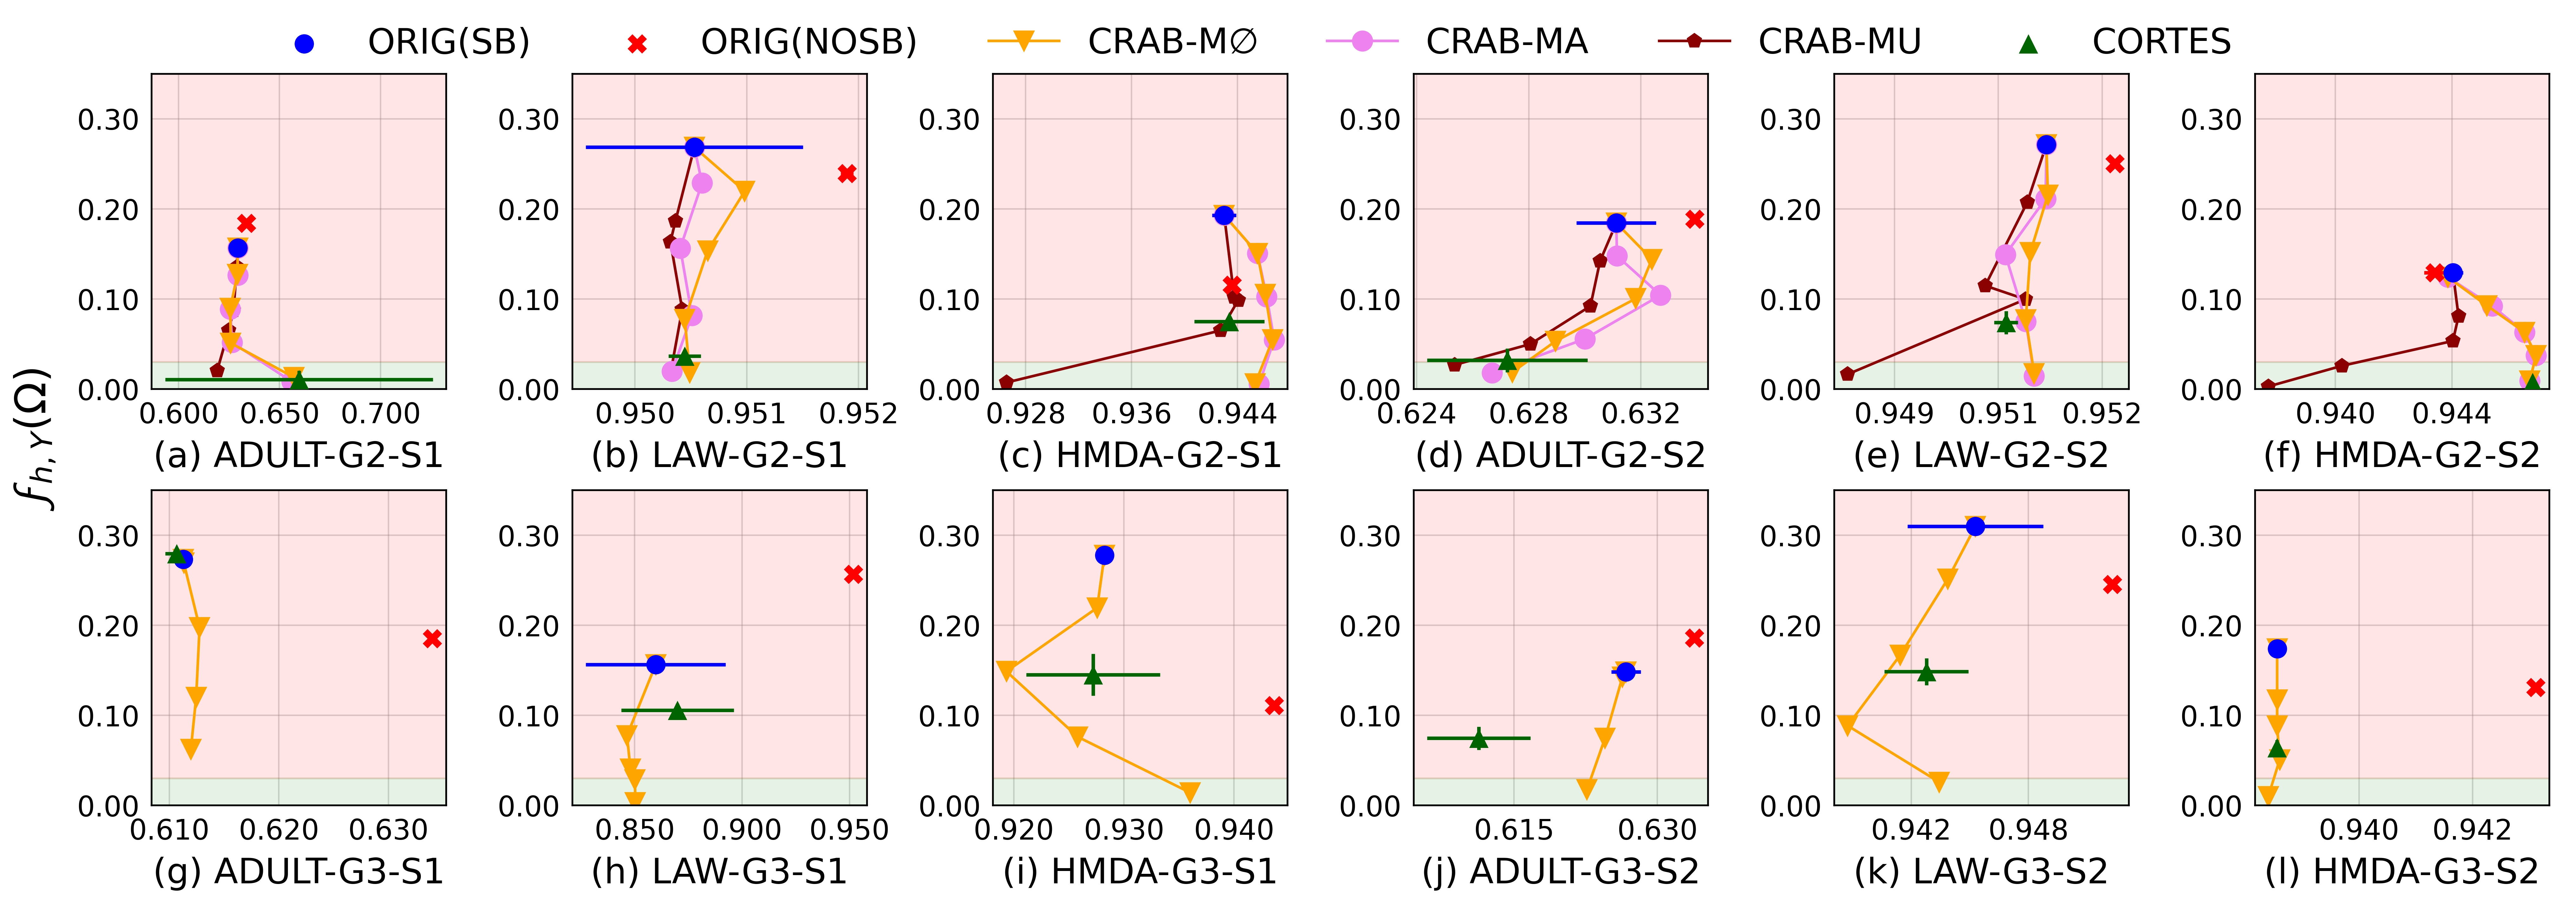

In [13]:
# double row
cnt = 0
fig, axs = plt.subplots(2, 6, dpi=400, figsize=(21, 7))
# methods = ['Orig', 'Bound Reg.', 'BF Reg.', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.']
# colors = ['blue', 'red', 'orange', 'violet', 'green', 'olive', 'purple']
methods = ['Orig', 'IPW', 'Test']
colors = ['blue', 'darkgreen', 'red']
markers = ['o', '^', 'X']

for m in ['EO']:
    dict_name = m + '_LR.dict'
    with open(dict_name, 'r') as f:
        txt = f.read()
        d = json.loads(txt)
    for sc in [5, 2, 3, 6]:
        for ds in ['adult', 'law', 'hmda']:
            col_id = (cnt%6)
            row_id = (cnt//6)
            ax = axs[row_id][col_id]
            afs = dict()
            test_accs = dict()
            mts = []
            for method in methods:
                mt = method
                mts.append(mt)
                afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
                test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
            af_mean = [np.mean(afs[mt]) for mt in mts]
            acc_mean = [np.mean(test_accs[mt]) for mt in mts]
            af_std = [np.std(afs[mt]) for mt in mts]
            acc_std = [np.std(test_accs[mt]) for mt in mts]
            ylabel = None
            xlabel = None
            if sc in [2, 5]:
                ths = tightbound_th_dict[f'{ds}-{sc}']
                plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
                          label='TightBound Reg.', color='darkred', marker='p', markersize=8)
            ths = est_th_dict[f'{ds}-{sc}']
            if sc in [2, 5]:
                plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
                          color='violet', marker='o', markersize=10.95)
            plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
                      color='orange', marker='v', markersize=10.95)
            single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                           f'({plot_alphabet[cnt]}) {ds.upper()}-G{row_id+2}-S{(sc_mapping[sc]-1)%2+1}',
                           xlabel, ylabel, label_size=10,
                           title_size=20, legend_size=5, ticksize=16, markersize=120)
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))
            ax.set_ylim(0, 0.35)
            xleft, xright = ax.get_xlim()
            ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
            ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
            ax.set_xlim(xleft, xright)
            ax.grid(color='grey', linestyle='-', alpha=0.3)
            ax.set_zorder(3)
            cnt += 1

lines, labels = axs[0][0].get_legend_handles_labels()
order = [3, 5, 2, 1, 0, 4]
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
                 fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.06), fancybox=False,
                 framealpha=0.0, prop={'size': 20})
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [120]
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('\n\nF1-Score', fontsize=20)
plt.ylabel(f'{EO_STR}\n', fontsize=24)

plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/est-comparison.pdf', bbox_inches='tight')

threshold for bounds


unbiased model (trained on the test set)

In [ ]:
# Bound
bound_th_dict = {'adult-1': [0.05, 0.14, 0.3, 0.35, 1.0]}
tightbound_th_dict = {'adult-1': [0.02, 0.08, 0.12, 0.17, 1.0]}
est_th_dict = {'adult-1': [0.01, 0.06, 0.11, 0.16, 1.0]}

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# # methods = ['AF Reg.-' + str(t) for t in [0.03, 0.05, 0.07, 0.09, 0.11, 0.15]]
# methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.', 'Test']
# colors = ['blue', 'orange', 'olive', 'green', 'violet', 'red']
# markers = ['o', 'v', 'p', 's', '*', 'X']
# for m in ['SPD']:
#     dict_name = m + '_LR.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][6] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Scenario {sc_mapping[sc]}', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=120)
#                 ths = bound_th_dict[f'{ds}-{sc}']
#                 plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
#                           color='darkcyan', marker='d', markersize=6)

# lines, labels = ax.get_legend_handles_labels()
# order = [0, 6, 4, 1, 2, 3, 5]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
#                  prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [120]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Statistical Parity\n', fontsize=20)
# plt.tight_layout()

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# methods = ['Orig', 'IPW']
# colors = ['blue', 'green']
# markers = ['o', 'p']
# for m in ['SPD']:
#     dict_name = m + '_LR.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-1] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
                
#                 ths = tightbound_th_dict[f'{ds}-{sc}']
#                 plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
#                           label='TightBound Reg.', color='purple', marker='v', markersize=8)
                
#                 ths = est_th_dict[f'{ds}-{sc}']
#                 plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
#                           color='violet', marker='o', markersize=8)
#                 plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
#                           color='orange', marker='v', markersize=8)
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Scenario {sc_mapping[sc]}', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=80)

# lines, labels = ax.get_legend_handles_labels()
# order = [3, 2, 0, 1, 4]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False,
#                  framealpha=0.0, prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Statistical Parity\n', fontsize=20)

# plt.tight_layout()

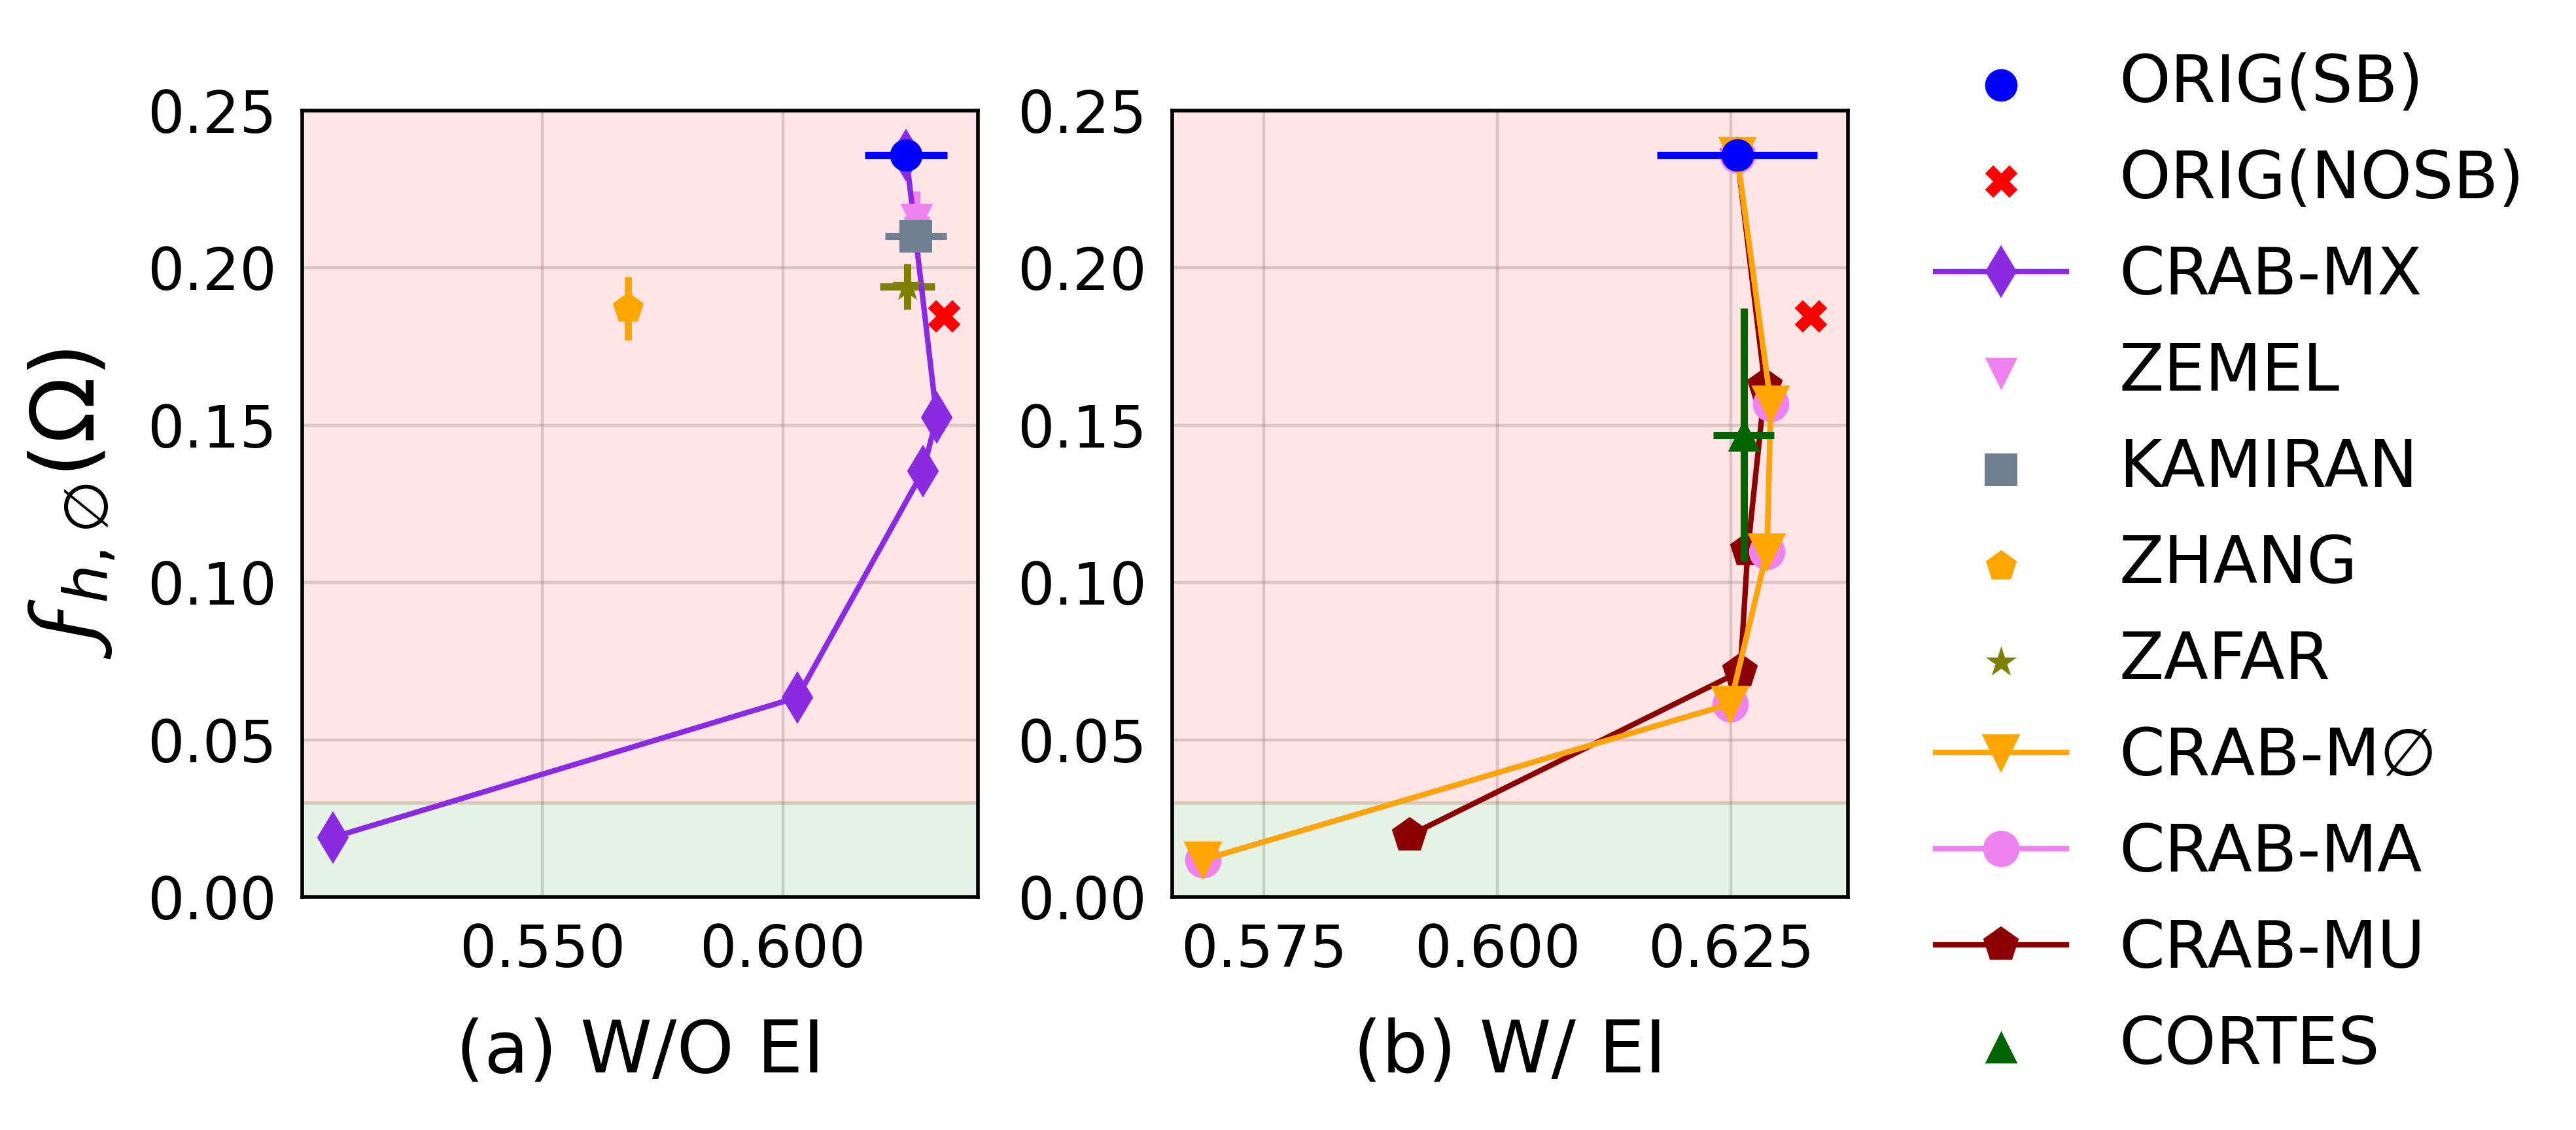

In [14]:
# 1*2 plots for SPD
fig, axs = plt.subplots(1, 2, dpi=400, figsize=(8, 4.5))

bound_th_dict = {'adult-1': [0.05, 0.14, 0.3, 0.35, 1.0]}
tightbound_th_dict = {'adult-1': [0.02, 0.08, 0.12, 0.17, 1.0]}
est_th_dict = {'adult-1': [0.01, 0.06, 0.11, 0.16, 1.0]}

ax = axs[0]
methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.', 'Test']
colors = ['blue', 'orange', 'violet', 'slategrey', 'olive', 'red']
markers = ['o', 'p', 'v', 's', '*', 'X', 'o']

m = 'SPD'
ds, sc = 'adult', 1
cnt = 0
dict_name = m + '_LR.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(a) W/O EI', xlabel, ylabel, label_size=10,
                   title_size=20, legend_size=5, ticksize=16, markersize=80, title_offset=-0.25)
    ths = bound_th_dict[f'{ds}-{sc}']
    plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
              color='blueviolet', marker='d', markersize=9)
    ax.set_ylim(0, 0.25)
    xleft, xright = ax.get_xlim()
    ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
    ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
    ax.set_xlim(xleft, xright)
    ax.grid(color='grey', linestyle='-', alpha=0.3)
    ax.set_zorder(3)
    cnt += 1

ax = axs[1]
methods = ['Orig', 'IPW', 'Test']
colors = ['blue', 'darkgreen', 'red']
markers = ['o', '^', 'X']
dict_name = m + '_LR.dict'
cnt = 0
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]

    ths = tightbound_th_dict[f'{ds}-{sc}']
    plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
              label='TightBound Reg.', color='darkred', marker='p', markersize=9)

    ths = est_th_dict[f'{ds}-{sc}']
    plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
              color='violet', marker='o', markersize=9)
    plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
              color='orange', marker='v', markersize=9)
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(b) W/ EI', xlabel, ylabel, label_size=10,
                   title_size=20, legend_size=5, ticksize=16, markersize=80, title_offset=-0.25)
    ax.set_ylim(0, 0.25)
    xleft, xright = ax.get_xlim()
    ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
    ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
    ax.set_xlim(xleft, xright)
    ax.grid(color='grey', linestyle='-', alpha=0.3)
    ax.set_zorder(3)
    cnt += 1


# lines, labels = axs[0].get_legend_handles_labels()
# order = [0, 6, 4, 1, 2, 3, 5]
# lgd = axs[0].legend([lines[i] for i in order], [labels[i] for i in order], loc='upper left',
#                        fontsize=30, ncol=6, bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
#                        prop={'size': 12})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]

lines0, labels0 = axs[0].get_legend_handles_labels()
lines1, labels1 = axs[1].get_legend_handles_labels()
lines, labels = lines0+lines1, labels0+labels1

order = [0, 5, 6, 2, 3, 1, 4, 9, 8, 7, 11]

# print([labels[i] for i in order])

lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='center',
                       fontsize=30, ncol=1, bbox_to_anchor=(1.15, 0.55), fancybox=False, framealpha=0.0,
                       prop={'size': 18})
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [80]

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('F1-Score', fontsize=20)
plt.ylabel(SPD_STR, fontsize=24)
ax.xaxis.set_label_coords(0.5, -0.28)
ax.yaxis.set_label_coords(-0.12, 0.5)
plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/spd-comparison.pdf', bbox_inches='tight')

In [ ]:
# bound_th_dict = {'adult-1': [0.05, 0.14, 0.3, 0.35, 1.0]}
# tightbound_th_dict = {'adult-1': [0.02, 0.09, 0.15, 0.22, 1.0]}
# est_th_dict = {'adult-1': [0.02, 0.08, 0.14, 0.2, 1.0]}

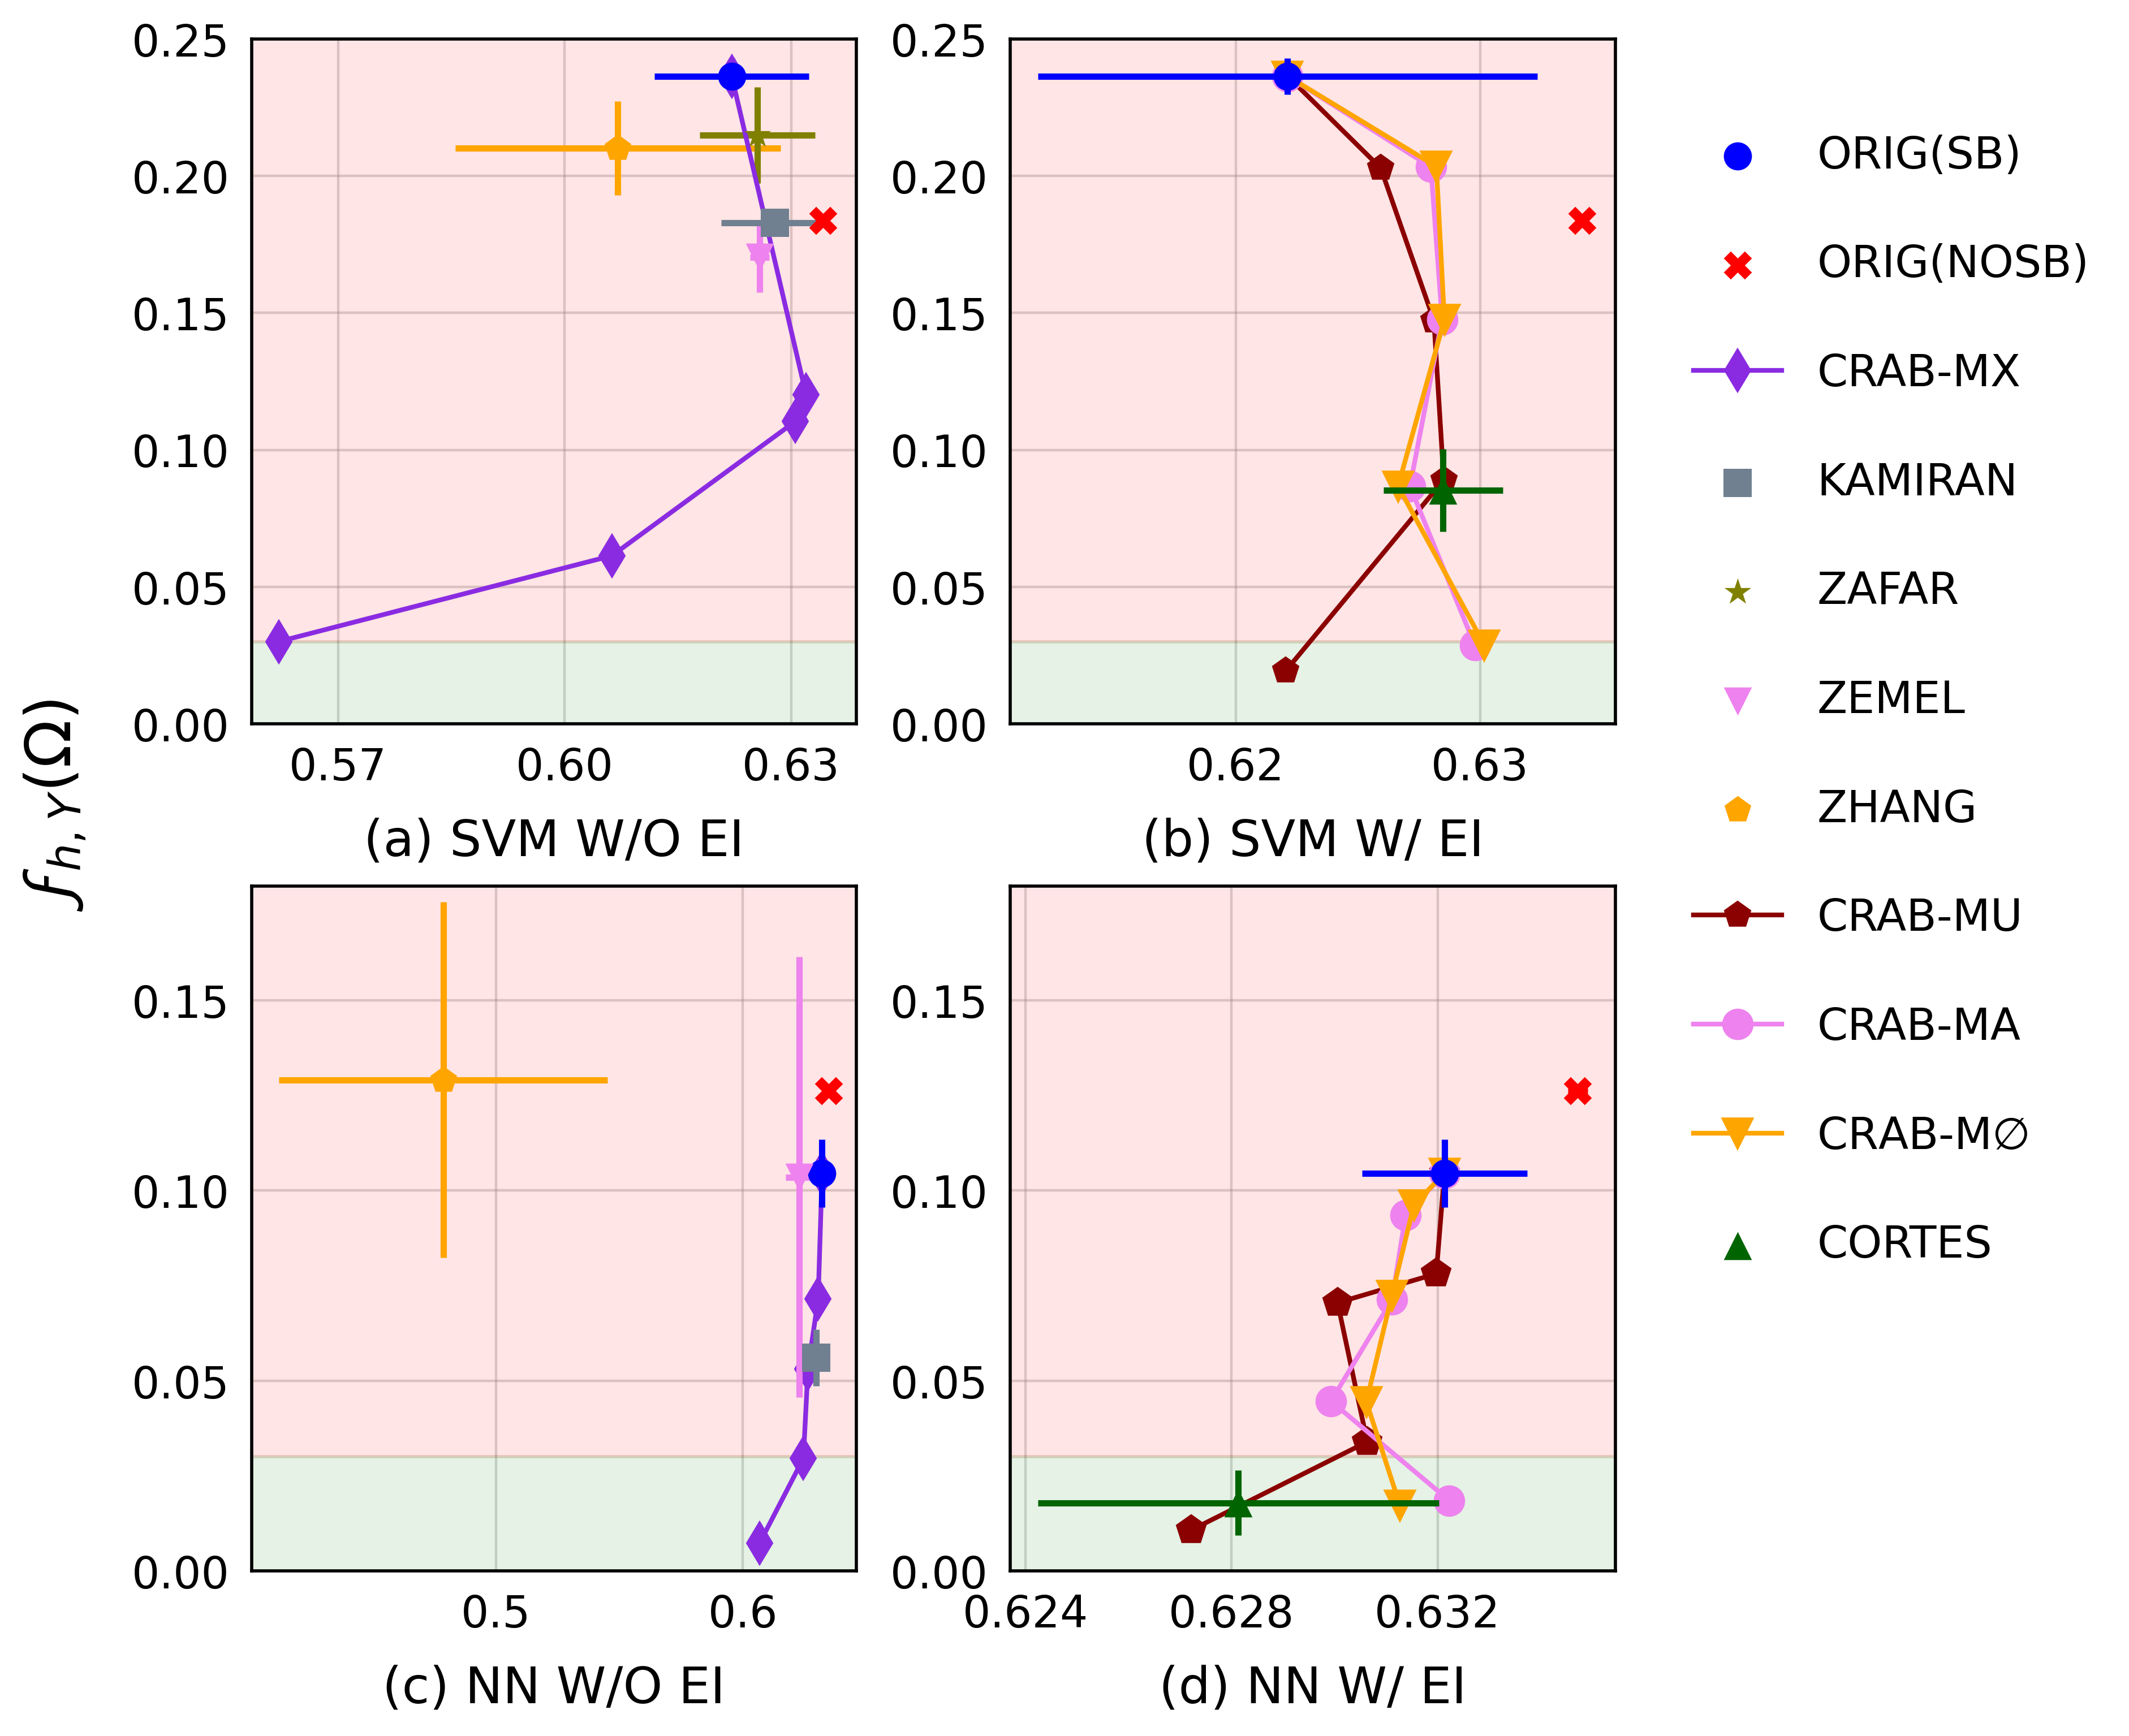

In [ ]:
# 2*2 plots for SVM/NN
fig, axs = plt.subplots(2, 2, dpi=400, figsize=(8, 8))

bound_th_dict = {'adult-1': [0.05, 0.14, 0.3, 0.35, 1.0]}
tightbound_th_dict = {'adult-1': [0.02, 0.09, 0.15, 0.22, 1.0]}
est_th_dict = {'adult-1': [0.02, 0.08, 0.14, 0.2, 1.0]}

ax = axs[0][0]
methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.', 'Test']
colors = ['blue', 'orange', 'violet', 'slategrey', 'olive', 'red']
markers = ['o', 'p', 'v', 's', '*', 'X', 'o']

m = 'EO'
ds, sc = 'adult', 1

dict_name = m + '_SVM.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   '(a) SVM W/O EI', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.22)
    ths = bound_th_dict[f'{ds}-{sc}']
    plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
              color='blueviolet', marker='d', markersize=9)
    ax.set_ylim(0, 0.25)

ax = axs[0][1]
methods = ['Orig', 'IPW', 'Test']
colors = ['blue', 'darkgreen', 'red']
markers = ['o', '^', 'X']
dict_name = m + '_SVM.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]

    ths = tightbound_th_dict[f'{ds}-{sc}']
    plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
              label='TightBound Reg.', color='darkred', marker='p', markersize=8)

    ths = est_th_dict[f'{ds}-{sc}']
    plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
              color='violet', marker='o', markersize=9)
    plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
              color='orange', marker='v', markersize=9)
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(b) SVM W/ EI', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.22)
    ax.set_ylim(0, 0.25)

bound_th_dict = {'adult-1': [0.07, 0.15, 0.3, 0.35, 1.0]}
tightbound_th_dict = {'adult-1': [0.01, 0.03, 0.07, 0.09, 1.0]}
est_th_dict = {'adult-1': [0.01, 0.04, 0.07, 0.1, 1.0]}

ax = axs[1][0]
methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Test']
colors = ['blue', 'orange', 'violet', 'slategrey', 'red']
markers = ['o', 'p', 'v', 's', 'X']
dict_name = m + '_NN.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    ths = bound_th_dict[f'{ds}-{sc}']
    plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
              color='blueviolet', marker='d', markersize=9)
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(c) NN W/O EI', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.22)
    ax.set_ylim(0, 0.18)

ax = axs[1][1]
methods = ['Orig', 'IPW', 'Test']
colors = ['blue', 'darkgreen', 'red']
markers = ['o', '^', 'X']
dict_name = m + '_NN.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]

    ths = tightbound_th_dict[f'{ds}-{sc}']
    plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
              label='TightBound Reg.', color='darkred', marker='p', markersize=9)

    ths = est_th_dict[f'{ds}-{sc}']
    plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
              color='violet', marker='o', markersize=9)
    plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
              color='orange', marker='v', markersize=9)
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(d) NN W/ EI', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.22)
    ax.set_ylim(0, 0.18)

for i in range(2):
    for j in range(2):
        ax = axs[i][j]
        xleft, xright = ax.get_xlim()
        ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
        ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
        ax.set_xlim(xleft, xright)
        ax.grid(color='grey', linestyle='-', alpha=0.3)
        ax.set_zorder(3)

# lines, labels = axs[0][0].get_legend_handles_labels()
# order = [0, 6, 4, 1, 2, 3, 5]
# lgd = axs[0][0].legend([lines[i] for i in order], [labels[i] for i in order], loc='center left',
#                        fontsize=30, ncol=1, bbox_to_anchor=(-0.04, 0.53), fancybox=False, framealpha=0.0,
#                        prop={'size': 12})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]

# lines, labels = axs[0][1].get_legend_handles_labels()
# order = [3, 2, 1, 0, 4, 5]
# lgd = axs[0][1].legend([lines[i] for i in order], [labels[i] for i in order], loc='center left',
#                        fontsize=30, ncol=1, bbox_to_anchor=(-0.04, 0.53), fancybox=False, framealpha=0.0,
#                        prop={'size': 12})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes

lines0, labels0 = axs[0][0].get_legend_handles_labels()
lines1, labels1 = axs[0][1].get_legend_handles_labels()
lines, labels = lines0+lines1, labels0+labels1
order = [0, 5, 6, 3, 4, 2, 1, 7, 8, 9, 11]
# print([labels[i] for i in order])
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='center',
                       fontsize=30, ncol=1, bbox_to_anchor=(1.12, 0.6), fancybox=False, framealpha=0.0,
                       prop={'size': 14}, labelspacing=1.5)
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [80]

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('F1-Score', fontsize=20)
plt.ylabel(EO_STR, fontsize=20)
# ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.12, 0.5)
plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/svm-nn-comparison.pdf', bbox_inches='tight')

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# methods = ['Orig', 'IPW', 'Test']
# colors = ['blue', 'green', 'red']
# markers = ['o', 's', 'X']
# for m in ['EO']:
#     dict_name = m + '_SVM.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-1] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
                
#                 ths = tightbound_th_dict[f'{ds}-{sc}']
#                 plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
#                           label='TightBound Reg.', color='purple', marker='v', markersize=8)
                
#                 ths = est_th_dict[f'{ds}-{sc}']
#                 plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
#                           color='violet', marker='o', markersize=8)
#                 plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
#                           color='orange', marker='v', markersize=8)
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Scenario {sc_mapping[sc]} (SVM)', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=80)

# lines, labels = ax.get_legend_handles_labels()
# order = [3, 2, 0, 1, 4, 5]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False,
#                  framealpha=0.0, prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Equalized Odds\n', fontsize=20)

# plt.tight_layout()

In [ ]:
# bound_th_dict = {'adult-1': [0.07, 0.15, 0.3, 0.35, 1.0]}
# tightbound_th_dict = {'adult-1': [0.01, 0.03, 0.07, 0.09, 1.0]}
# est_th_dict = {'adult-1': [0.01, 0.04, 0.07, 0.1, 1.0]}

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# methods = ['Orig', 'Adv. Debias', 'LFR', 'Reweighing', 'Cov. Reg.', 'Test']
# colors = ['blue', 'orange', 'olive', 'green', 'violet', 'red']
# markers = ['o', 'v', 'p', 's', '*', 'X']
# for m in ['EO']:
#     dict_name = m + '_NN.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-1] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Scenario {sc_mapping[sc]} (NN)', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=120)
#                 ths = bound_th_dict[f'{ds}-{sc}']
#                 plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
#                           color='darkcyan', marker='d', markersize=6)
# #                 cnt += 1

# lines, labels = ax.get_legend_handles_labels()
# order = [0, 6, 4, 1, 2, 3, 5]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
#                  prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [120]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Equalized Odds\n', fontsize=20)
# plt.tight_layout()

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# methods = ['Orig', 'IPW', 'Test']
# colors = ['blue', 'green', 'red']
# markers = ['o', 's', 'X']
# for m in ['EO']:
#     dict_name = m + '_NN.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-1] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
                
#                 ths = tightbound_th_dict[f'{ds}-{sc}']
#                 plot_line('TightBound Reg.', ds, sc, dict_name, ax, ths,
#                           label='TightBound Reg.', color='purple', marker='v', markersize=8)
                
#                 ths = est_th_dict[f'{ds}-{sc}']
#                 plot_line('Est.AF Reg.', ds, sc, dict_name, ax, ths, label='Est.AF Reg.',
#                           color='violet', marker='o', markersize=8)
#                 plot_line('AF Reg.', ds, sc, dict_name, ax, ths, label='AF Reg.',
#                           color='orange', marker='v', markersize=8)
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Scenario {sc_mapping[sc]} (NN)', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=80)

# lines, labels = ax.get_legend_handles_labels()
# order = [3, 2, 0, 1, 4]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False,
#                  framealpha=0.0, prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Equalized Odds\n', fontsize=20)

# plt.tight_layout()

In [23]:
def plot_line_double(method, ds, sc, dict_name, axs, ths, offset, label, color, marker, markersize=12):
    with open(dict_name, 'r') as f:
        txt = f.read()
        d = json.loads(txt)
    test_afs = dict()
    test_accs = dict()
    methods = [f'{method}-{th}' for th in ths]
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds if mt in d[ds][f'sc{sc}'][str(vs)]]
    af_mean = np.array([np.mean(afs[mt]) for mt in methods])
    acc_mean = np.array([np.mean(test_accs[mt]) for mt in methods])
    af_std = np.array([np.std(afs[mt]) for mt in methods])
    acc_std = np.array([np.std(test_accs[mt]) for mt in methods])
    axs[0].bar(ths+offset, af_mean, 4, label=get_name(label), yerr=af_std, color=color)
#     axs[0].fill_between(ths, (af_mean-af_std), (af_mean+af_std), color=color, alpha=.1)
    axs[1].bar(ths+offset, acc_mean, 4, label=get_name(label), yerr=acc_std, color=color)
#     axs[1].fill_between(ths, (acc_mean-acc_std), (acc_mean+acc_std), color=color, alpha=.1)
    axs[0].set_xlim(min(ths)-10, max(ths)+10)
    axs[1].set_xlim(min(ths)-10, max(ths)+10)
    axs[0].set_xticks(ths)
    axs[1].set_xticks(ths)
    axs[0].set_ylabel('$\digamma_{h, Y}(\Omega)$', fontsize=32)
    axs[1].set_ylabel('F1-Score', fontsize=32)
    axs[1].set_ylim(0.55, 0.65)
    axs[0].yaxis.set_major_locator(plt.MaxNLocator(6))
    axs[1].yaxis.set_major_locator(plt.MaxNLocator(6))
    for ax in axs:
        ax.tick_params(colors='white', direction='out')
        for tick in ax.get_xticklabels():
            tick.set_fontsize(24)
            tick.set_color('black')
        for tick in ax.get_yticklabels():
            tick.set_color('black')
            tick.set_fontsize(24)
    for j in range(2):
        axs[j].yaxis.set_label_coords(-0.1, 0.5)
#     axs[1].xaxis.set_label_coords(0.5, 0.5)
    

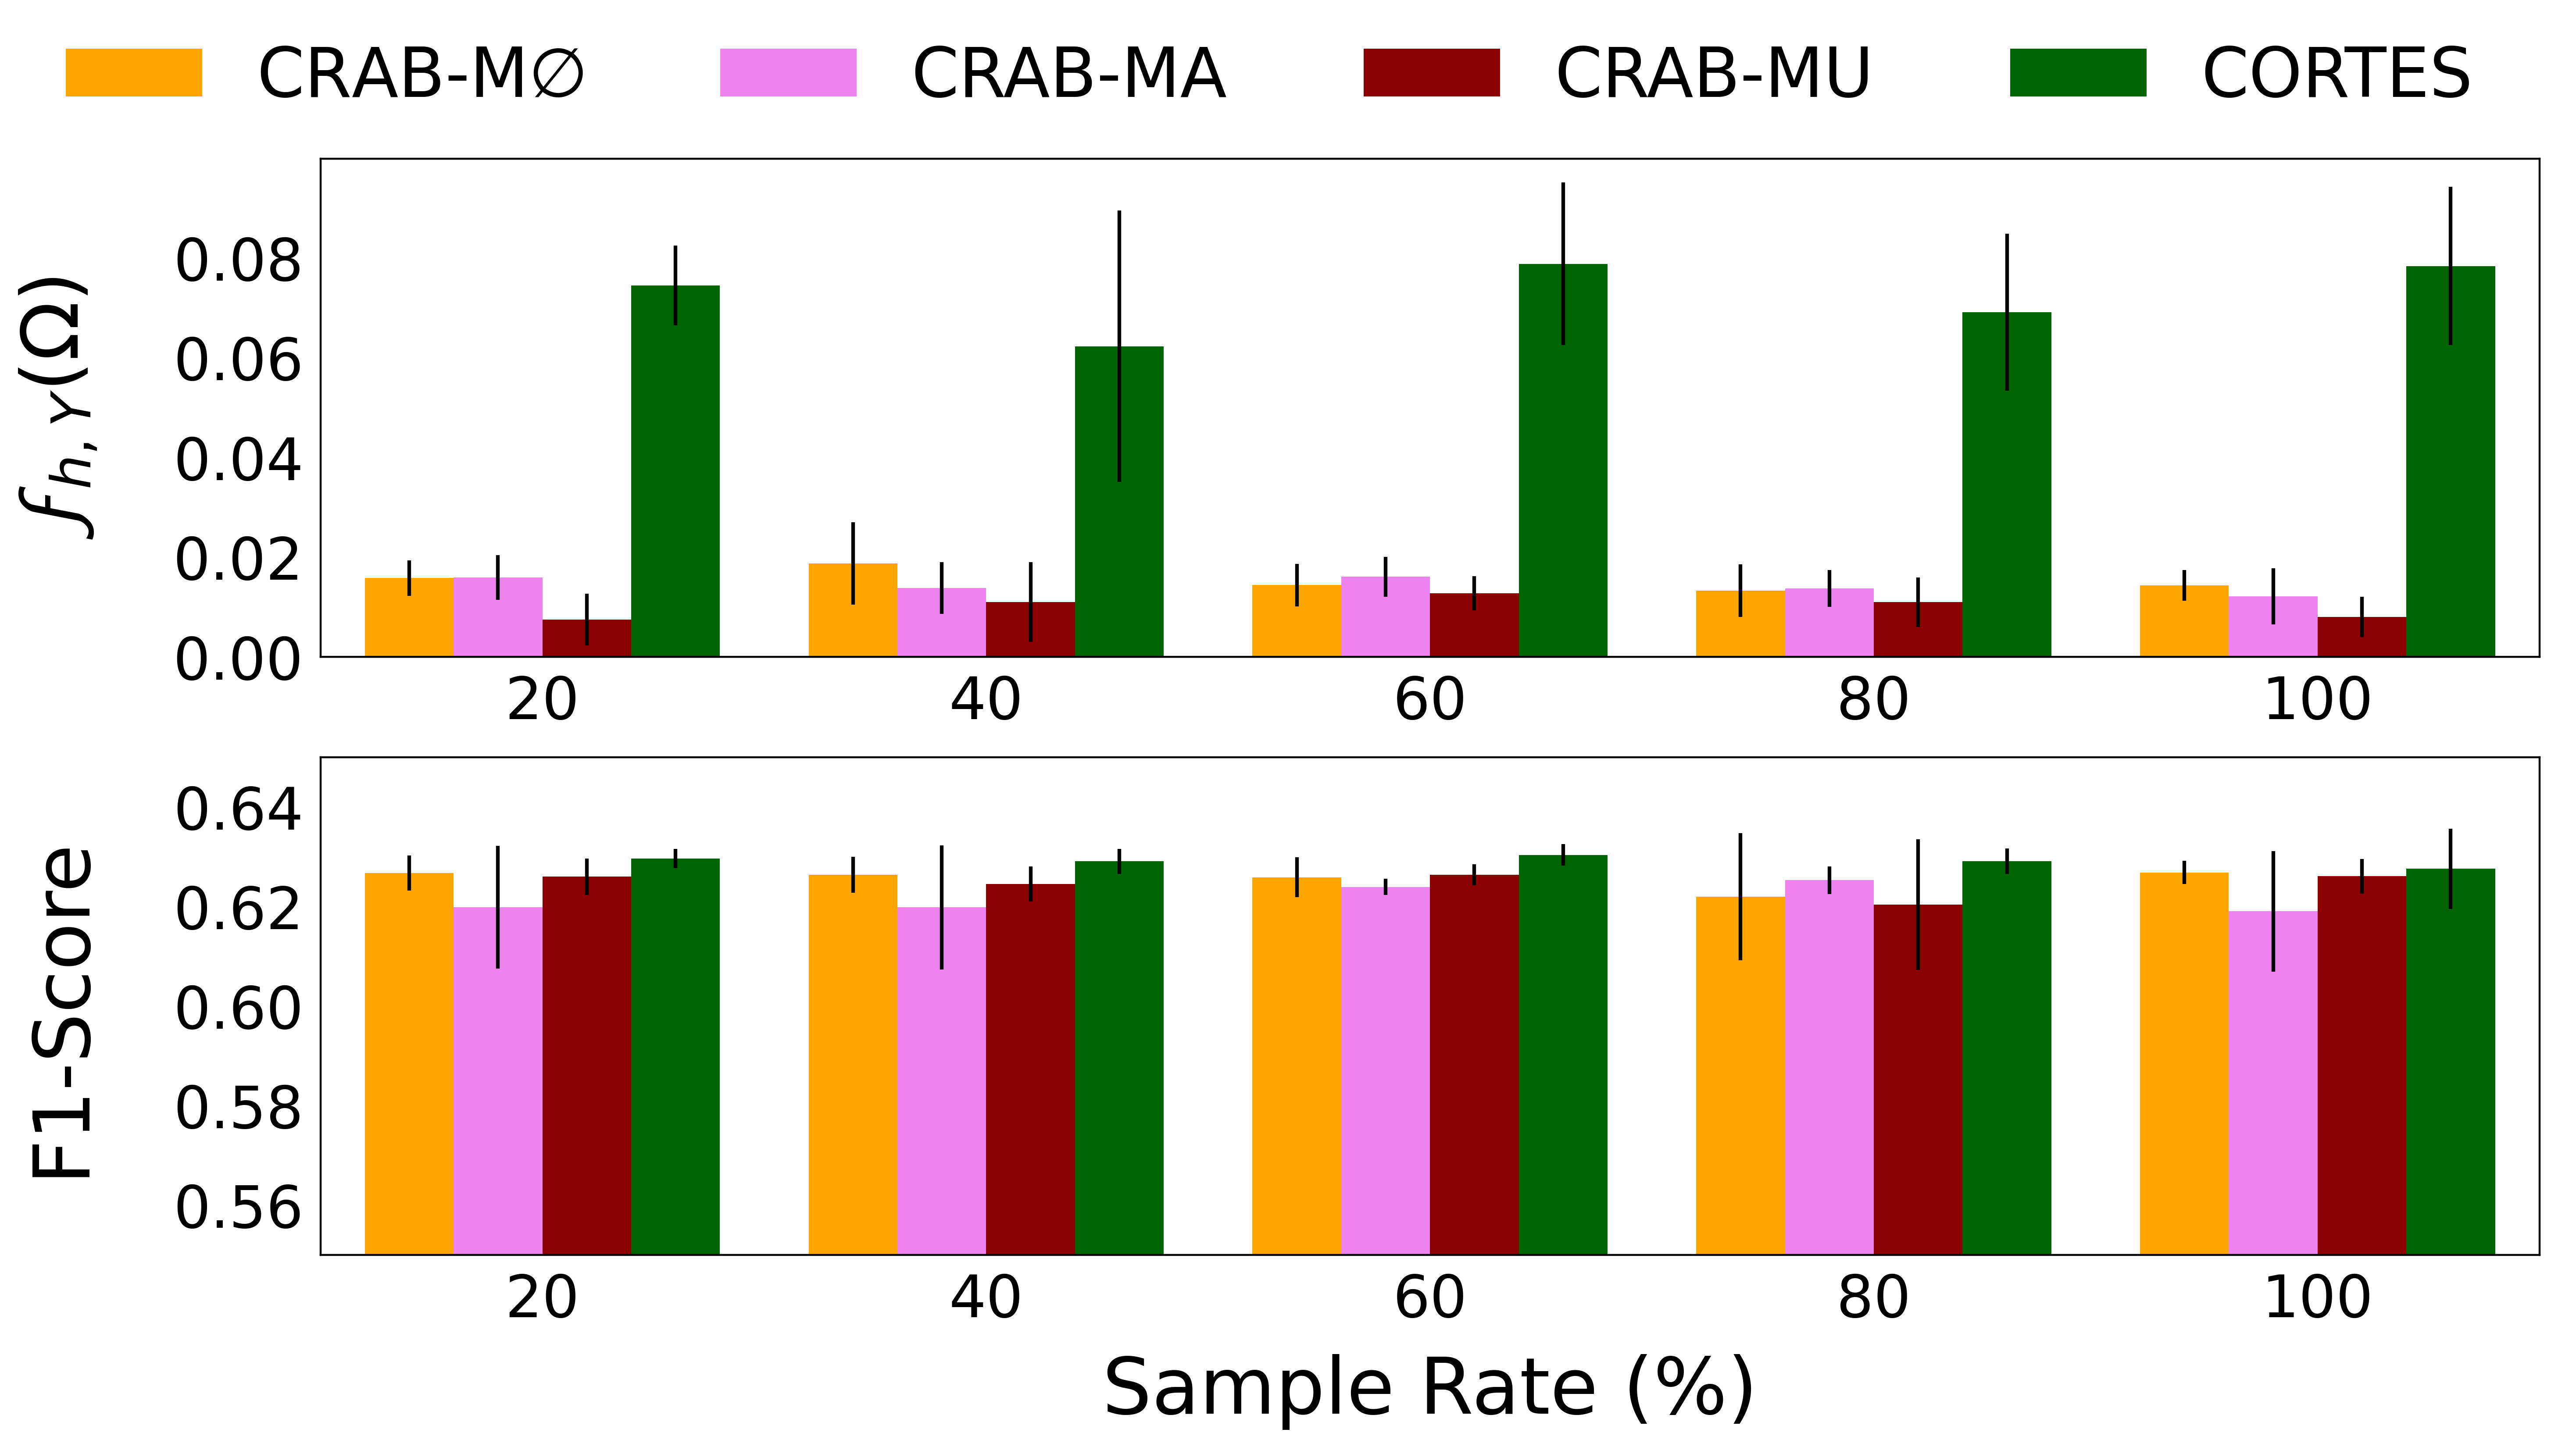

In [28]:
# single
fig, axs = plt.subplots(2, 1, dpi=400, figsize=(15, 8))
# methods = ['Orig', 'IPW']
# colors = ['blue', 'green']
# markers = ['o', 'p']
for m in ['EO']:
    dict_name = m + '_LR.dict'
    with open(dict_name, 'r') as f:
        txt = f.read()
        d = json.loads(txt)
        for ds in ['adult']:
            for sc in [1]:
#                 ths = np.array([10, 20, 30, 40, 50])
                ths =  np.array([20, 40, 60, 80, 100])
                plot_line_double('AF Reg.-0.01', ds, sc, dict_name, axs, ths, -6, label='AF Reg.',
                                 color='orange', marker='v', markersize=8)
                plot_line_double('Est.AF Reg.-0.01', ds, sc, dict_name, axs, ths, -2, label='Est.AF Reg.',
                                 color='violet', marker='o', markersize=8)
                plot_line_double('TightBound Reg.-0.01', ds, sc, dict_name, axs, ths, 2,
                                 label='TightBound Reg.', color='darkred', marker='p', markersize=8)
                plot_line_double('IPW', ds, sc, dict_name, axs, ths, 6, label='IPW',
                                 color='darkgreen', marker='s', markersize=8)

lines, labels = axs[0].get_legend_handles_labels()
order = [0, 1, 2, 3]
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
                 fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False,
                 framealpha=0.0, prop={'size': 28})
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [120]

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Sample Rate (%)', fontsize=32)
ax.xaxis.set_label_coords(0.5, -0.09)
# plt.ylabel('Equalized Odds\n', fontsize=20)

plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/subsample-comparison.pdf', bbox_inches='tight')

In [ ]:
# # single
# fig, axs = plt.subplots(2, 1, dpi=400, figsize=(15, 8))
# # methods = ['Orig', 'IPW']
# # colors = ['blue', 'green']
# # markers = ['o', 'p']
# for m in ['EO']:
#     dict_name = m + '_LR.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['adult']:
#             for sc in [1]:
#                 ths = np.array([20, 40, 60, 80, 100])
#                 plot_line_double('TightBound Reg.-0.03', ds, sc, dict_name, axs, ths,
#                                  label='TightBound Reg.', color='purple', marker='v', markersize=8)
#                 plot_line_double('Est.AF Reg.-0.03', ds, sc, dict_name, axs, ths, label='Est.AF Reg.',
#                                  color='violet', marker='o', markersize=8)
#                 plot_line_double('AF Reg.-0.03', ds, sc, dict_name, axs, ths, label='AF Reg.',
#                                  color='orange', marker='v', markersize=8)
#                 plot_line_double('IPW', ds, sc, dict_name, axs, ths, label='IPW',
#                                  color='darkgreen', marker='s', markersize=8)

# lines, labels = axs[0].get_legend_handles_labels()
# order = [3, 2, 0, 1]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fancybox=False,
#                  framealpha=0.0, prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [80]

# ax = fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('Sample Rate (%)', fontsize=20)
# ax.xaxis.set_label_coords(0.5, -0.07)
# # plt.ylabel('Equalized Odds\n', fontsize=20)

# plt.tight_layout()
# plt.savefig('/Users/lodino/Desktop/subsample-comparison.pdf', bbox_inches='tight')

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# # methods = ['AF Reg.-' + str(t) for t in [0.03, 0.05, 0.07, 0.09, 0.11, 0.15]]
# methods = ['Orig', 'AF Reg.-0.0', 'TightBound Reg.-0.0', 'Test']
# colors = ['blue', 'orange', 'violet', 'green', 'olive', 'red']
# markers = ['o', 'v', 'p', 's', '*', 'd', 'o']
# for m in ['EO']:
#     dict_name = m + '_LR.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['hmda']:
#             for sc in [7]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-1] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Calcasieu', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=120)

# lines, labels = ax.get_legend_handles_labels()
# order = [0, 1, 2, 3]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
#                  prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [120]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Statistical Parity\n', fontsize=20)
# plt.tight_layout()

In [ ]:
# # single
# fig = plt.figure(figsize=(6, 6), dpi=100)
# ax = plt.subplot(111)
# # methods = ['AF Reg.-' + str(t) for t in [0.03, 0.05, 0.07, 0.09, 0.11, 0.15]]
# methods = ['Orig', 'AF Reg.-0.0', 'TightBound Reg.-0.0', 'Test']
# colors = ['blue', 'orange', 'violet', 'green', 'olive', 'red']
# markers = ['o', 'v', 'p', 's', '*', 'd', 'o']
# for m in ['EO']:
#     dict_name = m + '_LR.dict'
#     with open(dict_name, 'r') as f:
#         txt = f.read()
#         d = json.loads(txt)
#         for ds in ['hmda']:
#             for sc in [8]:
#                 afs = dict()
#                 test_accs = dict()
#                 for mt in methods:
#                     afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
#                     test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][6] for vs in val_seeds]
#                 af_mean = [np.mean(afs[mt]) for mt in methods]
#                 acc_mean = [np.mean(test_accs[mt]) for mt in methods]
#                 af_std = [np.std(afs[mt]) for mt in methods]
#                 acc_std = [np.std(test_accs[mt]) for mt in methods]
#                 single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
#                                f'{ds} - Orleans', xlabel, ylabel, label_size=10,
#                                title_size=16, legend_size=5, ticksize=14, markersize=120)

# lines, labels = ax.get_legend_handles_labels()
# order = [0, 1, 2, 3]
# lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
#                  fontsize=30, ncol=len(labels), bbox_to_anchor=(0.5, 1.1), fancybox=False, framealpha=0.0,
#                  prop={'weight': 'bold', 'size': 18})
# for i in range(len(lgd.legendHandles)):
#     lgd.legendHandles[i]._sizes = [120]
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel('\nTest Accuracy', fontsize=20)
# plt.ylabel('Statistical Parity\n', fontsize=20)
# plt.tight_layout()

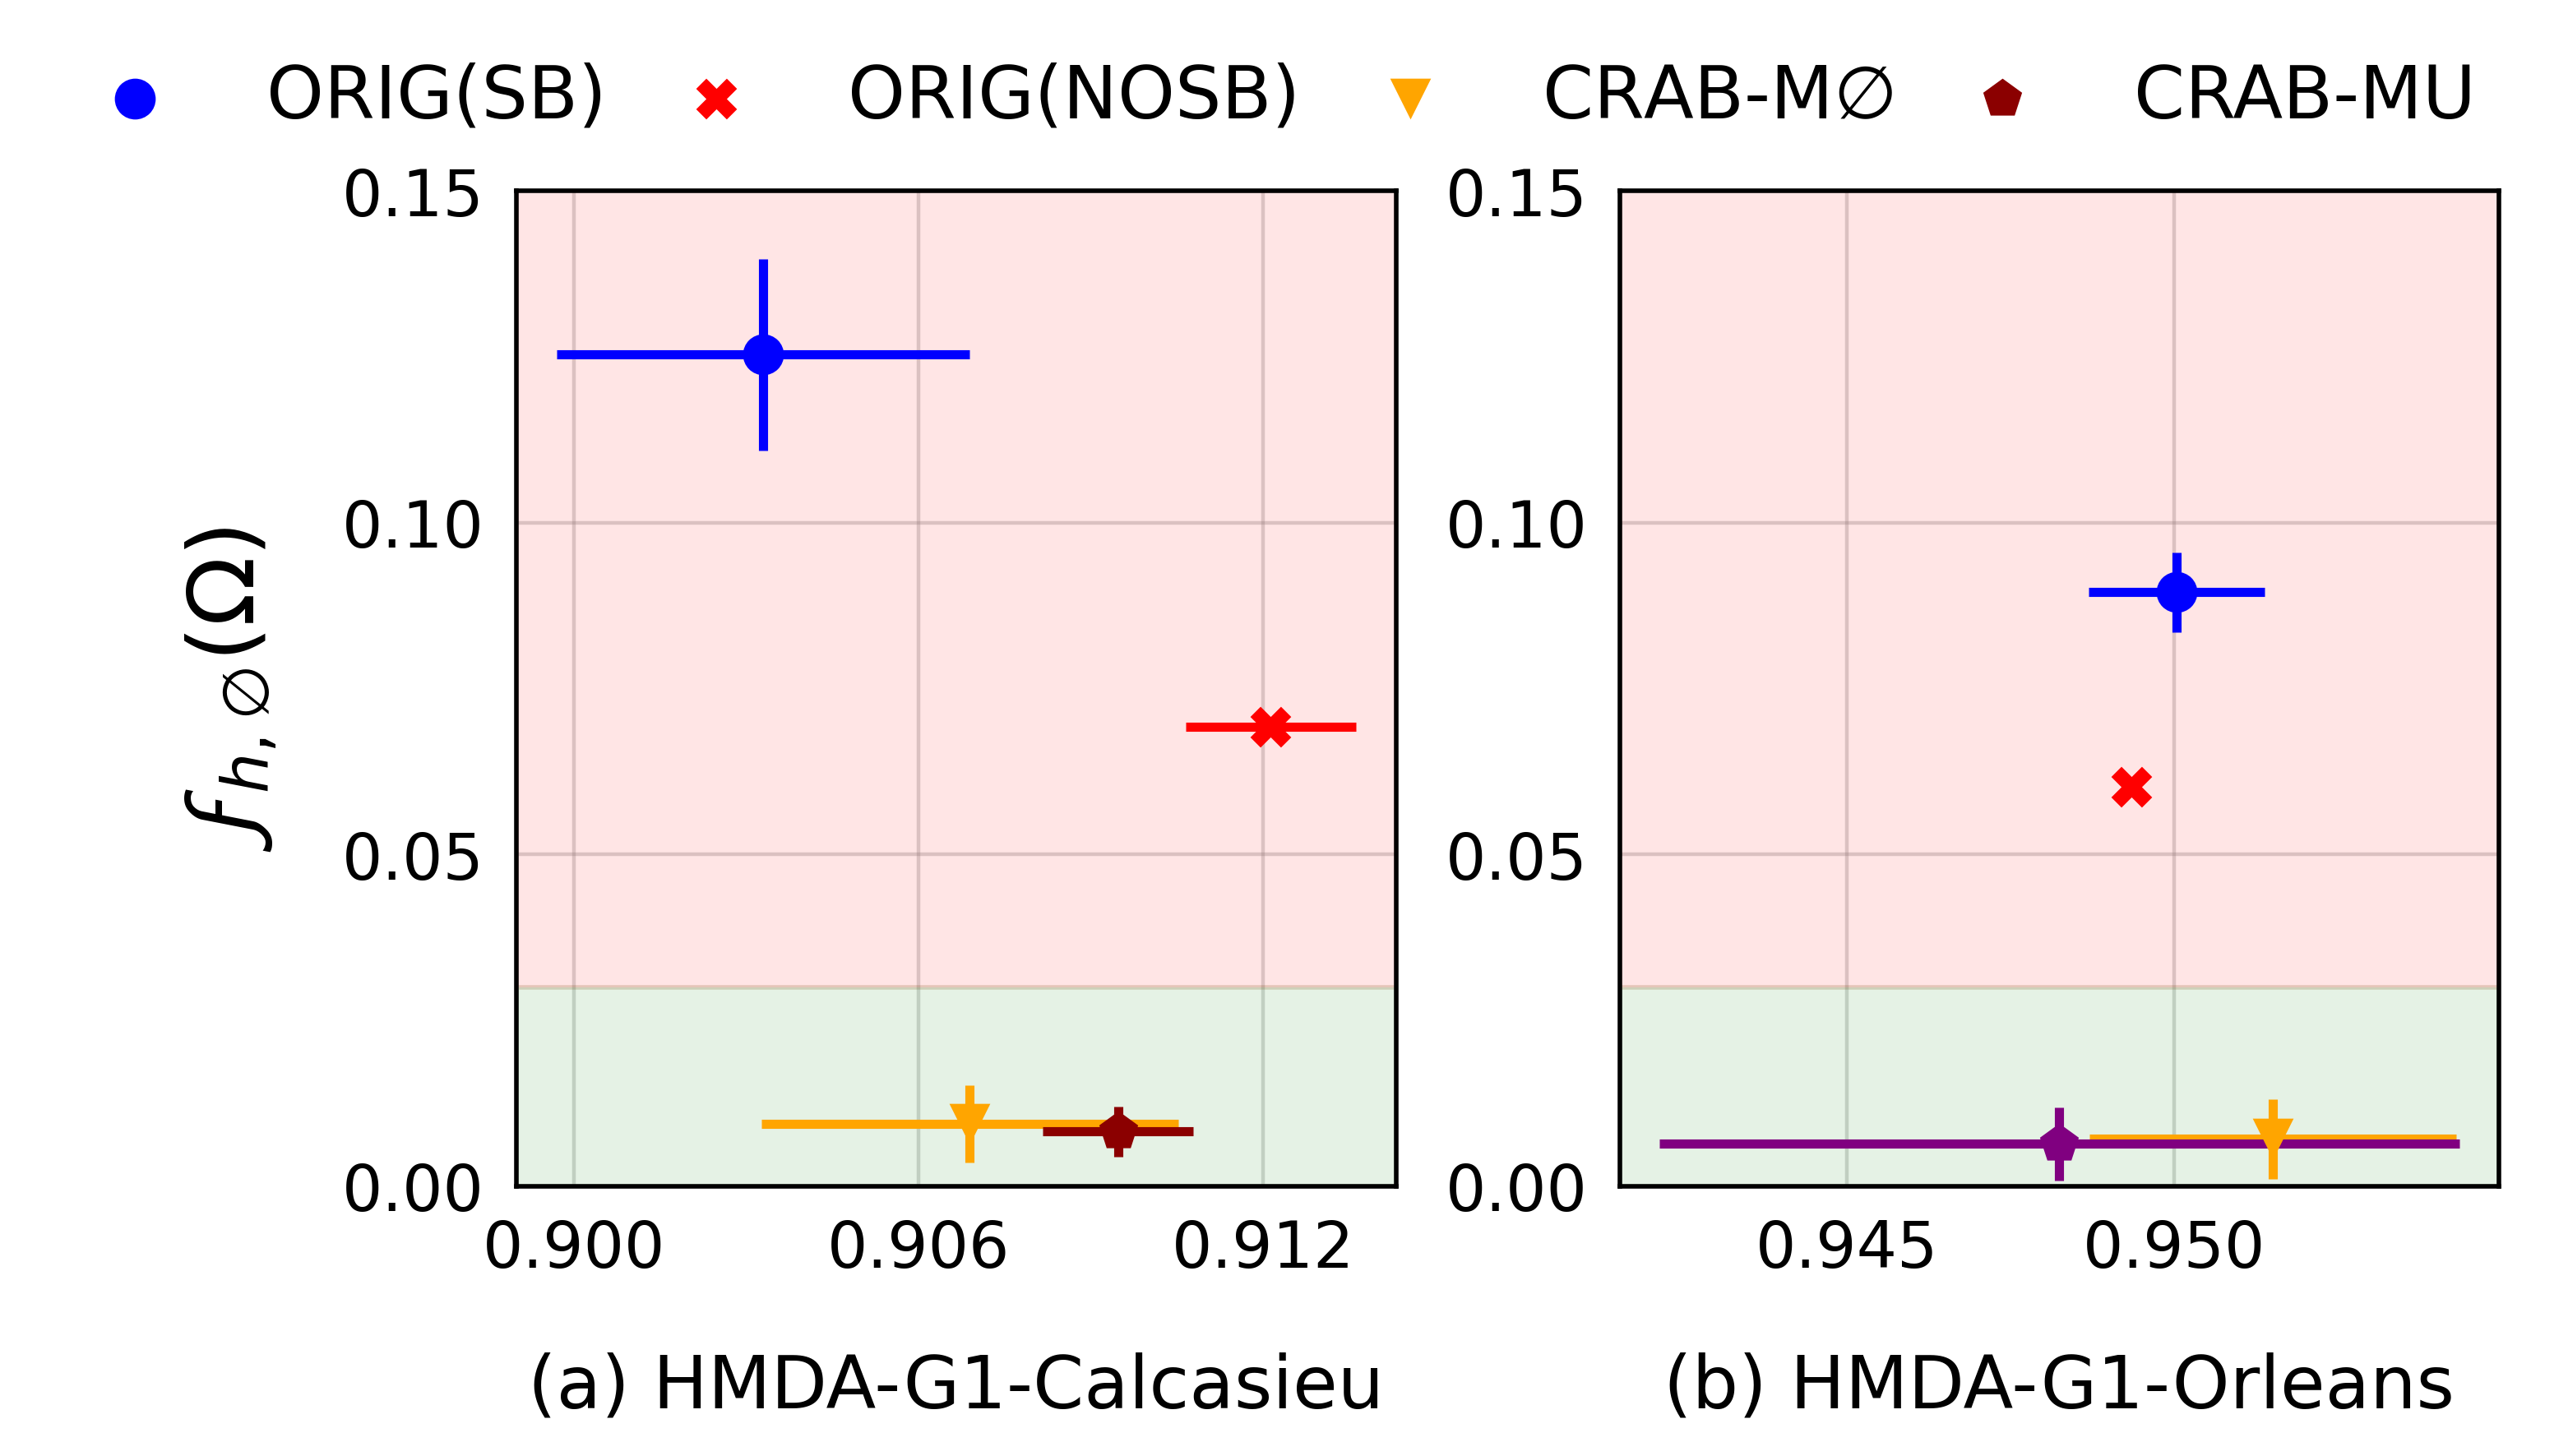

In [ ]:
# 1*2 plots for SPD
fig, axs = plt.subplots(1, 2, dpi=400, figsize=(8, 4.5))

bound_th_dict = {'adult-1': [0.05, 0.14, 0.3, 0.35, 1.0]}
tightbound_th_dict = {'adult-1': [0.02, 0.08, 0.12, 0.17, 1.0]}
est_th_dict = {'adult-1': [0.01, 0.06, 0.11, 0.16, 1.0]}

ax = axs[0]
methods = ['Orig', 'Test', 'AF Reg.-0.0', 'TightBound Reg.-0.0']
colors = ['blue', 'red', 'orange', 'darkred']
markers = ['o', 'X', 'v', 'p']

m = 'SPD'
ds, sc = 'hmda', 7

dict_name = m + '_LR.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'({plot_alphabet[0]}) {ds.upper()}-G1-Calcasieu', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.25)
    ax.set_ylim(0, 0.15)

ax = axs[1]
sc = 8
methods = ['Orig', 'AF Reg.-0.0', 'TightBound Reg.-0.0', 'Test']
colors = ['blue', 'orange', 'purple', 'red']
markers = ['o', 'v', 'p', 'X']
dict_name = m + '_LR.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'({plot_alphabet[1]}) {ds.upper()}-G1-Orleans', xlabel, ylabel, label_size=10,
                   title_size=16, legend_size=5, ticksize=14, markersize=80, title_offset=-0.25)
    ax.set_ylim(0, 0.15)


for i in range(2):
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
    ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
    ax.set_xlim(xleft, xright)
    ax.grid(color='grey', linestyle='-', alpha=0.3)
    ax.set_zorder(3)

lines, labels = axs[0].get_legend_handles_labels()
order = [0, 1, 2, 3]
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
                 fontsize=30, ncol=len(lines), bbox_to_anchor=(0.5, 1.07), fancybox=False, framealpha=0.0,
                 prop={'size': 16}, columnspacing=0.5)
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [80]

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('F1-Score', fontsize=20)
plt.ylabel(SPD_STR, fontsize=20)
# ax.xaxis.set_label_coords(0.5, -0.28)
ax.yaxis.set_label_coords(-0.12, 0.5)

plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/real-ratio-comparison.pdf', bbox_inches='tight')

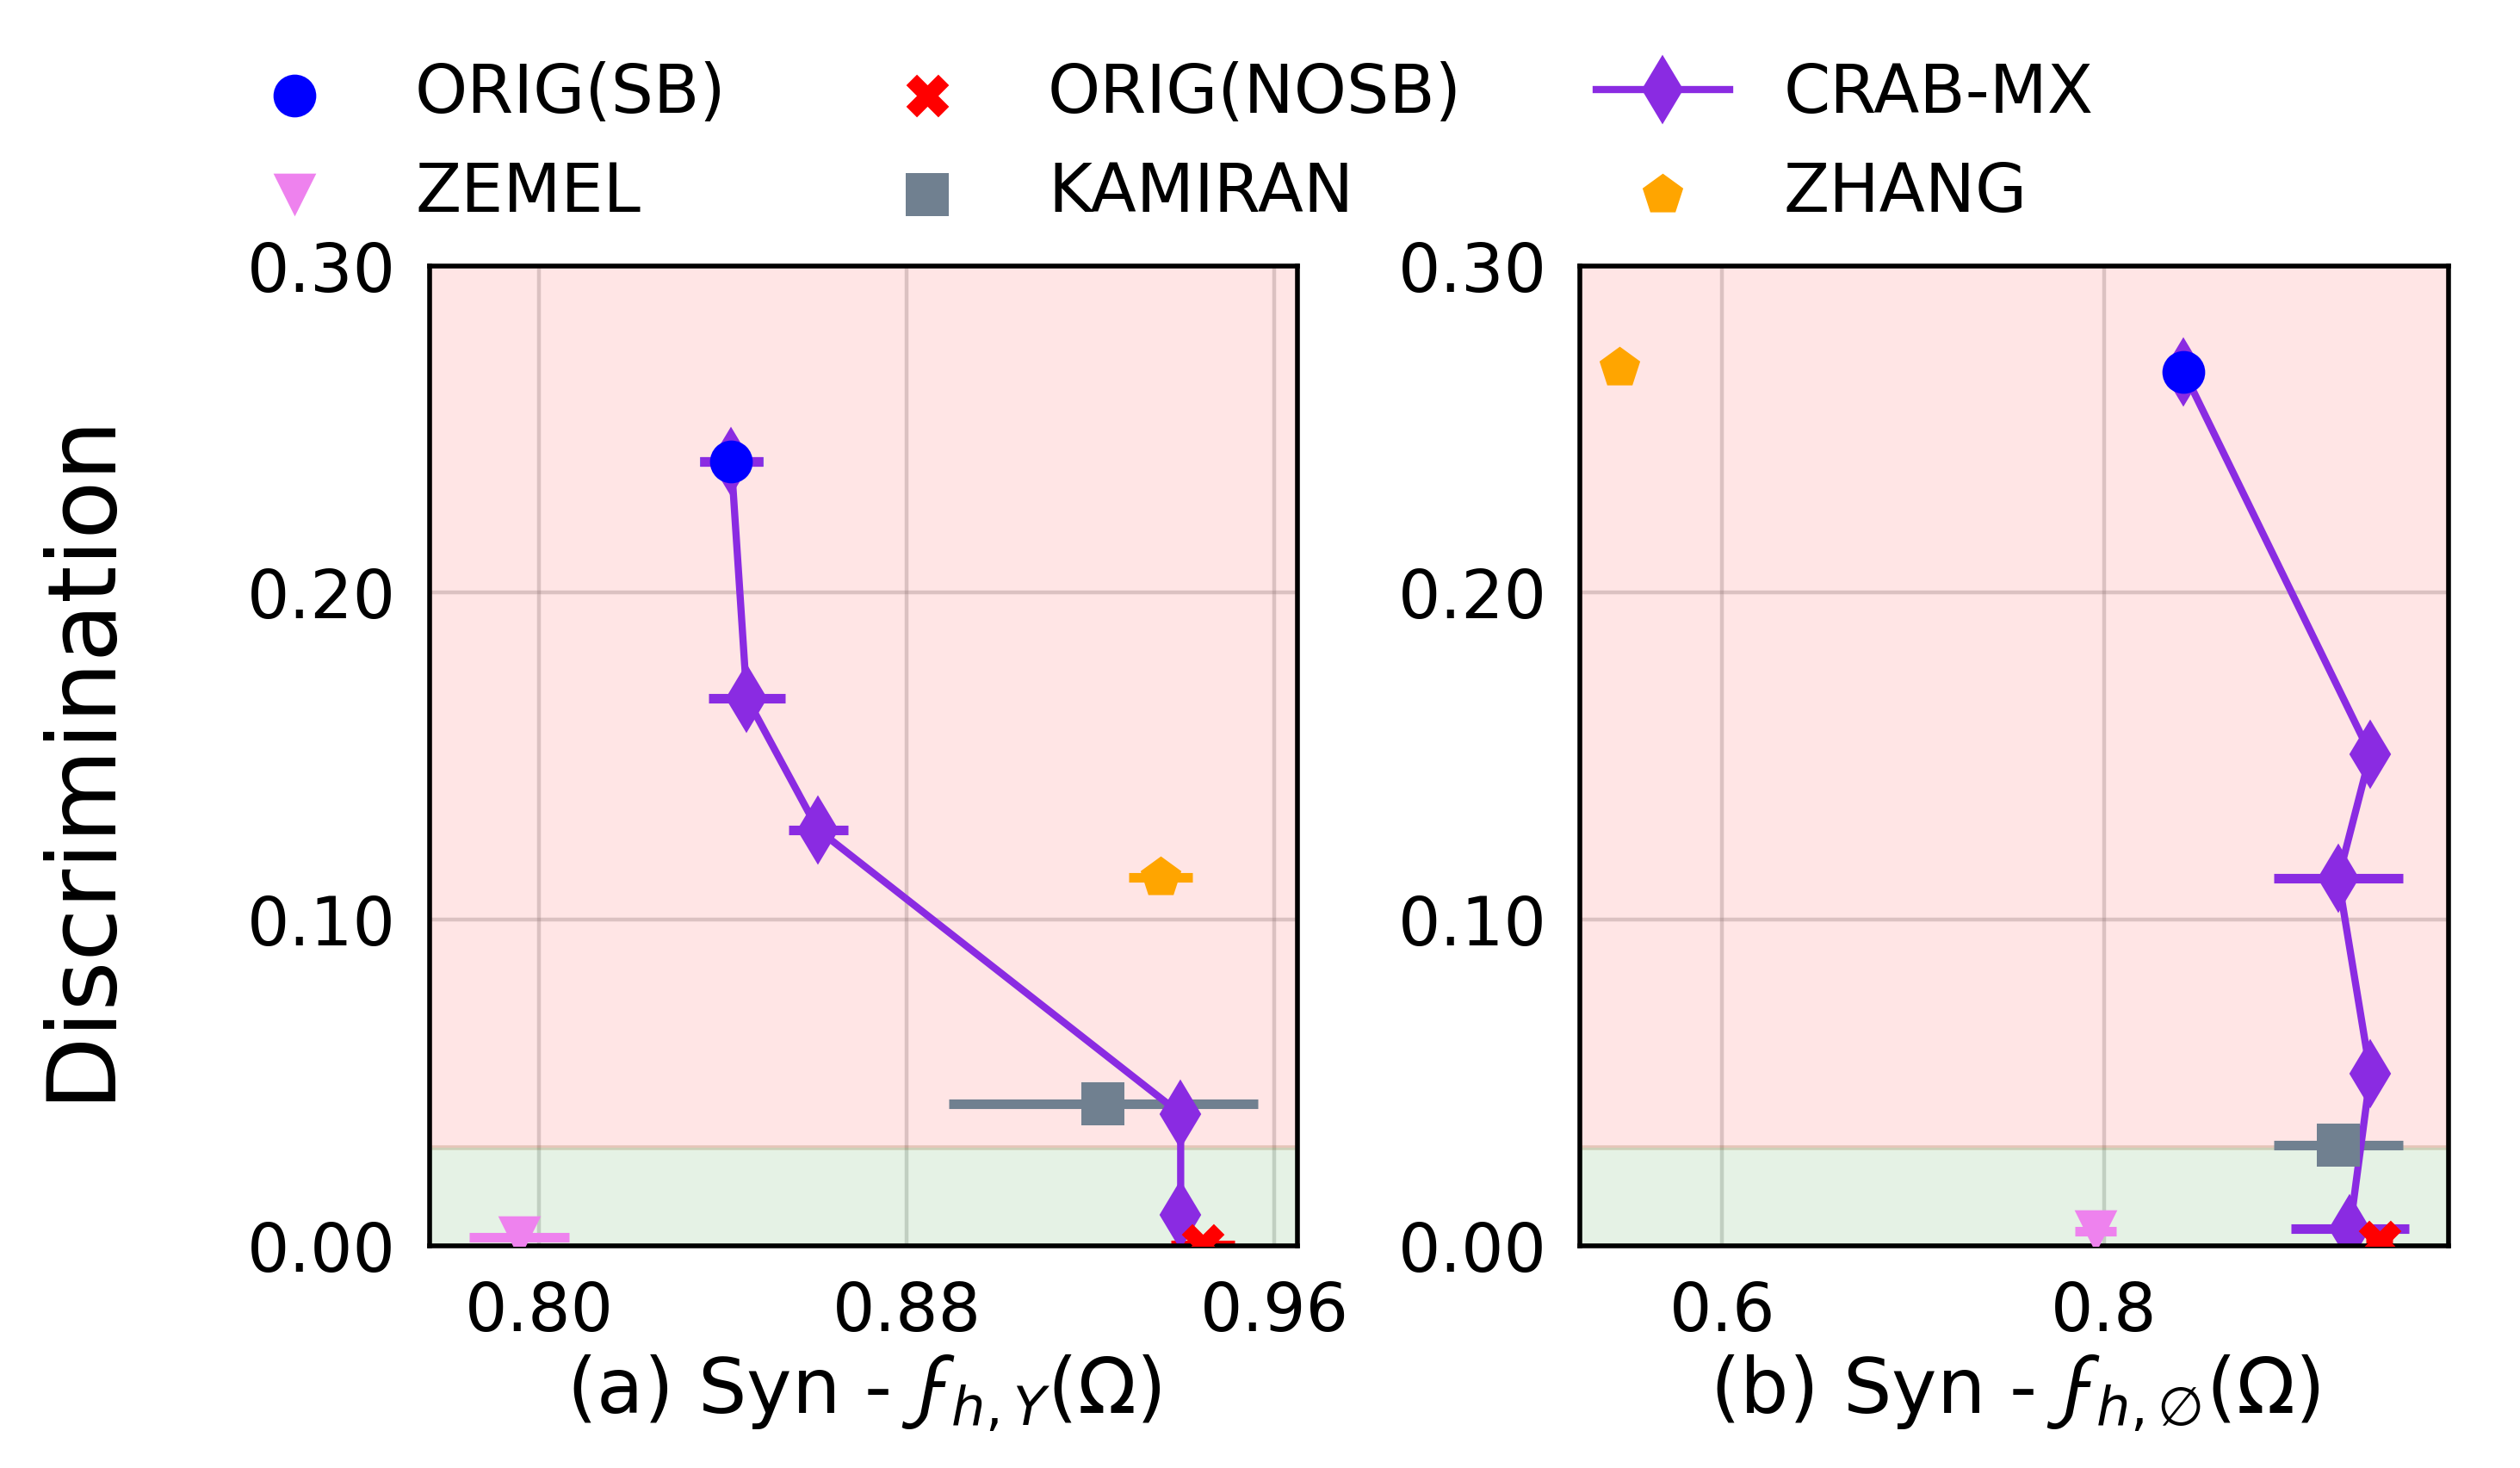

In [ ]:
# 1*2 plots for SPD
fig, axs = plt.subplots(1, 2, dpi=400, figsize=(8, 4.1))

bound_th_dict = {'syn-1': [0.0, 0.05, 0.15, 0.2, 1.0]}
# tightbound_th_dict = {'adult-1': [0.02, 0.08, 0.12, 0.17, 1.0]}
# est_th_dict = {'syn-1': [0.00, 0.06, 0.11, 0.16, 1.0]}

methods = ['Orig', 'Test', 'Adv. Debias', 'LFR', 'Reweighing']
colors = ['blue', 'red', 'orange', 'violet', 'slategrey']
markers = ['o', 'X', 'p', 'v', 's']

ds, sc = 'syn', 1

ax = axs[0]
m = 'EO'
dict_name = m + '_LR.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(a) Syn - {EO_STR}', xlabel, ylabel, label_size=10, title_offset=-0.20,
                   title_size=16, legend_size=5, ticksize=14, markersize=80)
    ths = bound_th_dict[f'{ds}-{sc}']
    plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
              color='blueviolet', marker='d', markersize=9, err=True)
    ax.set_ylim(0, 0.3)
    xleft, xright = ax.get_xlim()
    ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
    ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
    ax.set_xlim(xleft, xright)
    ax.grid(color='grey', linestyle='-', alpha=0.3)
    ax.set_zorder(3)

bound_th_dict = {'syn-1': [0.05, 0.7, 0.8, 0.85, 1.0]}
ax = axs[1]
m = 'SPD'
dict_name = m + '_LR.dict'
with open(dict_name, 'r') as f:
    txt = f.read()
    d = json.loads(txt)
    afs = dict()
    test_accs = dict()
    for mt in methods:
        afs[mt] = [abs(d[ds][f'sc{sc}'][str(vs)][mt][0]) for vs in val_seeds]
        test_accs[mt] = [d[ds][f'sc{sc}'][str(vs)][mt][-2] for vs in val_seeds]
    af_mean = [np.mean(afs[mt]) for mt in methods]
    acc_mean = [np.mean(test_accs[mt]) for mt in methods]
    af_std = [np.std(afs[mt]) for mt in methods]
    acc_std = [np.std(test_accs[mt]) for mt in methods]
    single_scatter(ax, acc_mean, acc_std, af_mean, af_std, colors, methods, markers,
                   f'(b) Syn - {SPD_STR}', xlabel, ylabel, label_size=10, title_offset=-0.20,
                   title_size=16, legend_size=5, ticksize=14, markersize=80)
    ths = bound_th_dict[f'{ds}-{sc}']
    plot_line('Bound Reg.', ds, sc, dict_name, ax, ths, label='Bound Reg.',
              color='blueviolet', marker='d', markersize=9, err=True)
    ax.set_ylim(0, 0.3)
    xleft, xright = ax.get_xlim()
    ax.fill_between((xleft, xright), 0.03, 1, color='red', alpha=0.1)
    ax.fill_between((xleft, xright), 0, 0.02999, color='green', alpha=0.1)
    ax.set_xlim(xleft, xright)
    ax.grid(color='grey', linestyle='-', alpha=0.3)
    ax.set_zorder(3)

ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
lines, labels = axs[0].get_legend_handles_labels()
order = [0, 3, 1, 4, 5, 2]
lgd = fig.legend([lines[i] for i in order], [labels[i] for i in order], loc='upper center',
                fontsize=30, ncol=3, bbox_to_anchor=(0.5, 1.12), fancybox=False, framealpha=0.0,
                prop={'size': 14})
for i in range(len(lgd.legendHandles)):
    lgd.legendHandles[i]._sizes = [80]
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel('F1-Score', fontsize=20)
plt.ylabel('Discrimination', fontsize=20)
# ax.xaxis.set_label_coords(0.5, -0.2)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.tight_layout()
plt.savefig('/Users/lodino/Desktop/syn-comparison.pdf', bbox_inches='tight')